In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

!pip install geopandas pyarrow shapely pyproj rtree matplotlib pandas numpy openpyxl jupyterlab seaborn plotly scipy scikit-learn pulp

In [21]:
import sys
import os

# Add project root (two levels up)
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)
print(project_root)

/home/mak/Documents


In [3]:
!ls && pwd 
%cd /home/mak/Documents/Optimization/Project


2.ipynb
/home/mak/Documents/Optimization/Project/src/notebooks
/home/mak/Documents/Optimization/Project


In [4]:
wm = pd.read_csv("data/processed/master_weekly_table.csv")
wm = wm[(wm["year"] >= 2017) & (wm["year"] <= 2024)].copy()
wm.to_csv("data/processed/master_weekly_table_2017_2024.csv", index=False)

In [5]:
!ls

data		     illinois_corn_fields_synthetic.csv  src
data_cleaning.ipynb  schedule_output.csv


# 1️⃣ Make labor realistic (seasonal, not 5M hours every week)
Right now, after you build weekly_master, every row has the same labor_hours ≈ 5,057,910.
We’ll keep that as the annual pool, but scale it by week.

In [6]:
import numpy as np

# Assume weekly_master is already built and contains `year`, `week`, `labor_hours`
# wm = weekly_master.copy()

# (Optional) keep original labor for reference
wm["labor_hours_base"] = wm["labor_hours"]

def labor_season_factor(week: int) -> float:
    """
    Fraction of the annual labor pool effectively available in a given week.
    Tune these numbers as you like.
    """
    # Peak field activity during planting
    if 16 <= week <= 20:
        return 0.30      # 30% of annual workforce active in field

    # Peak field activity during harvest
    elif 36 <= week <= 45:
        return 0.40      # 40% of annual workforce

    # Shoulder / off-season
    else:
        return 0.10      # 10% in field operations

# Apply seasonal factor
wm["labor_hours"] = wm.apply(
    lambda r: r["labor_hours_base"] * labor_season_factor(int(r["week"])),
    axis=1,
)

# Overwrite weekly_master and resave
weekly_master = wm
weekly_master.to_csv("data/processed/master_weekly_table.csv", index=False)

weekly_master.head(15)


year  week  prcp_week_in       TMAX       TMIN       TAVG       AWND  \
0   2017     1      0.250769  25.728571   9.250000  17.942857   9.320779   
1   2017     2      0.432308  39.242857  21.814286  29.457143  10.768831   
2   2017     3      1.402564  47.242857  35.128571  40.342857   8.135065   
3   2017     4      0.080513  37.771429  29.285714  33.600000  11.251948   
4   2017     5      0.012564  37.792857  19.971429  29.942857  10.162338   
5   2017     6      0.416384  46.728571  24.442857  36.114286  11.287013   
6   2017     7      0.004615  56.705036  30.200000  43.857143   8.167532   
7   2017     8      0.272051  58.392857  36.657143  48.085714  10.910390   
8   2017     9      0.826667  52.726619  31.014286  42.742857  11.842857   
9   2017    10      0.438205  50.485714  31.900000  41.457143  11.945455   
10  2017    11      0.297306  42.726619  23.264286  34.200000   9.688312   
11  2017    12      0.842564  59.503597  38.700000  49.314286  11.288312   
12  2017    13      1.711538  55.364286  40.571429  47.714286   9.066234   
13  2017    14      1.447179  60.407143  42.207143  52.114286  12.568831   
14  2017    15      1.251765  72.278571  48.335714  62.257143   9.972727   

    capacity_factor rain_category  labor_hours  plant_start_week  \
0               0.9         light      5057.91                15   
1               0.9         light      5057.91                15   
2               0.7      moderate      5057.91                15   
3               0.9         light      5057.91                15   
4               0.9         light      5057.91                15   
5               0.9         light      5057.91                15   
6               0.9         light      5057.91                15   
7               0.9         light      5057.91                15   
8               0.7      moderate      5057.91                15   
9               0.9         light      5057.91                15   
10              0.9         light      5057.91                15   
11              0.7      moderate      5057.91                15   
12              0.4         heavy      5057.91                15   
13              0.7      moderate      5057.91                15   
14              0.7      moderate      5057.91                15   

    plant_end_week  harvest_start_week  harvest_end_week  is_plant_window  \
0               21                  36              45.0            False   
1               21                  36              45.0            False   
2               21                  36              45.0            False   
3               21                  36              45.0            False   
4               21                  36              45.0            False   
5               21                  36              45.0            False   
6               21                  36              45.0            False   
7               21                  36              45.0            False   
8               21                  36              45.0            False   
9               21                  36              45.0            False   
10              21                  36              45.0            False   
11              21                  36              45.0            False   
12              21                  36              45.0            False   
13              21                  36              45.0            False   
14              21                  36              45.0             True   

    is_harvest_window  labor_hours_base  
0               False           50579.1  
1               False           50579.1  
2               False           50579.1  
3               False           50579.1  
4               False           50579.1  
5               False           50579.1  
6               False           50579.1  
7               False           50579.1  
8               False           50579.1  
9               False           50579.1  
10 

In [7]:
"""
    🚀 4. Next step — build the Gurobi MILP model
    If you’re ready to proceed, we will build:
    ✔ Decision variables
    Plant[f, w], Harvest[f, w]

    ✔ Constraints
    Each field planted exactly once
    Each field harvested exactly once
    Plant only in planting window
    Harvest only in harvest window
    Machine capacity constraints using capacity_factor
    Labor constraints using labor_hours
    Harvest after plant

    ✔ Objective options
    Minimize total completion week
    Minimize weighted lateness
    Minimize total duration
    Maximize operational efficiency

    We’ll implement it cleanly in:

    src/optimization/milp_scheduler.py_summary_
"""

'\n    🚀 4. Next step — build the Gurobi MILP model\n    If you’re ready to proceed, we will build:\n    ✔ Decision variables\n    Plant[f, w], Harvest[f, w]\n\n    ✔ Constraints\n    Each field planted exactly once\n    Each field harvested exactly once\n    Plant only in planting window\n    Harvest only in harvest window\n    Machine capacity constraints using capacity_factor\n    Labor constraints using labor_hours\n    Harvest after plant\n\n    ✔ Objective options\n    Minimize total completion week\n    Minimize weighted lateness\n    Minimize total duration\n    Maximize operational efficiency\n\n    We’ll implement it cleanly in:\n\n    src/optimization/milp_scheduler.py_summary_\n'

In [8]:
!ls && pwd

data		     illinois_corn_fields_synthetic.csv  src
data_cleaning.ipynb  schedule_output.csv
/home/mak/Documents/Optimization/Project


In [9]:
from src.optimization.milp_scheduler import build_and_solve_schedule

schedule_2017 = build_and_solve_schedule(
    fields_path="data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="data/processed/master_weekly_table.csv",
    target_year=2017,
    base_planter_capacity=1000.0,
    base_harvester_capacity=600.0,
    labor_plant_per_acre=0.30,
    labor_harvest_per_acre=0.40,
    min_harvest_lag_weeks=6,
    time_limit=60
)

schedule_2017

Restricted license - for non-production use only - expires 2027-11-29
Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 249 rows, 476 columns and 1850 nonzeros (Min)
Model fingerprint: 0x6196115e
Model has 1 linear objective coefficients
Variable types: 51 continuous, 425 integer (425 binary)
Coefficient statistics:


  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Found heuristic solution: objective 45.0000000
Presolve removed 189 rows and 225 columns
Presolve time: 0.01s
Presolved: 60 rows, 251 columns, 750 nonzeros
Variable types: 0 continuous, 251 integer (250 binary)

Root relaxation: objective 3.745115e+01, 119 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   37.45115    0   53   45.00000   37.45115  16.8%     -    0s
H    0     0                      40.0000000   37.45115  6.37%     -    0s
H    0     0                      39.0000000   37.45115  3.97%     -    0s

Cutting planes:
  MIR: 1

Explored 1 nodes (153 simplex iterations) in 0.03 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 39 40 45 

Optimal

field_id  plant_week  harvest_week  plant_week_continuous  \
0      F001          16            37                   16.0   
1      F002          16            39                   16.0   
2      F003          19            37                   19.0   
3      F004          16            36                   16.0   
4      F005          16            38                   16.0   
5      F006          17            39                   17.0   
6      F007          19            37                   19.0   
7      F008          20            39                   20.0   
8      F009          15            39                   15.0   
9      F010          19            39                   19.0   
10     F011          19            39                   19.0   
11     F012          15            38                   15.0   
12     F013          15            36                   15.0   
13     F014          17            36                   17.0   
14     F015          21            37                   21.0   
15     F016          19            38                   19.0   
16     F017          21            37                   21.0   
17     F018          18            39                   18.0   
18     F019          15            36                   15.0   
19     F020          19            38                   19.0   
20     F021          16            38                   16.0   
21     F022          15            39                   15.0   
22     F023          19            36                   19.0   
23     F024          21            37                   21.0   
24     F025          20            38                   20.0   

    harvest_week_continuous  status  objective_makespan  
0                      37.0       2                39.0  
1                      39.0       2                39.0  
2                      37.0       2                39.0  
3                      36.0       2                39.0  
4                      38.0       2                39.0  
5                      39.0       2                39.0  
6                      37.0       2                39.0  
7                      39.0       2                39.0  
8                      39.0       2                39.0  
9                      39.0       2                39.0  
10                     39.0       2                39.0  
11                     38.0       2                39.0  
12                     36.0       2                39.0  
13                     36.0       2                39.0  
14                     37.0       2                39.0  
15                     38.0       2                39.0  
16                     37.0       2                39.0  
17                     39.0       2                39.0  
18                     36.0       2                39.0  
19                     38.0       2                39.0  
20                     38.0       2                39.0  
21                     39.0       2                39.0  
22                     36.0       2                39.0  
23                     37.0       2                39.0  
24                     38.0       2                39.0

In [10]:
schedule_2017.head(20)

field_id  plant_week  harvest_week  plant_week_continuous  \
0      F001          16            37                   16.0   
1      F002          16            39                   16.0   
2      F003          19            37                   19.0   
3      F004          16            36                   16.0   
4      F005          16            38                   16.0   
5      F006          17            39                   17.0   
6      F007          19            37                   19.0   
7      F008          20            39                   20.0   
8      F009          15            39                   15.0   
9      F010          19            39                   19.0   
10     F011          19            39                   19.0   
11     F012          15            38                   15.0   
12     F013          15            36                   15.0   
13     F014          17            36                   17.0   
14     F015          21            37                   21.0   
15     F016          19            38                   19.0   
16     F017          21            37                   21.0   
17     F018          18            39                   18.0   
18     F019          15            36                   15.0   
19     F020          19            38                   19.0   

    harvest_week_continuous  status  objective_makespan  
0                      37.0       2                39.0  
1                      39.0       2                39.0  
2                      37.0       2                39.0  
3                      36.0       2                39.0  
4                      38.0       2                39.0  
5                      39.0       2                39.0  
6                      37.0       2                39.0  
7                      39.0       2                39.0  
8                      39.0       2                39.0  
9                      39.0       2                39.0  
10                     39.0       2                39.0  
11                     38.0       2                39.0  
12                     36.0       2                39.0  
13                     36.0       2                39.0  
14                     37.0       2                39.0  
15                     38.0       2                39.0  
16                     37.0       2                39.0  
17                     39.0       2                39.0  
18                     36.0       2                39.0  
19                     38.0       2                39.0

3️⃣ (Optional but nice) Make harvest capacity more weather-sensitive

If you want harvest to match NASS even better, refine compute_harvest_weather_factor.

🔧 Where

In src/optimization/weather_capacity.py
Find your existing compute_harvest_weather_factor and replace it with:

In [11]:
fields = pd.read_csv("data/processed/illinois_corn_fields_clean.csv")
sched = schedule_2017.merge(fields, on="field_id", how="left")
sched.head()

field_id  plant_week  harvest_week  plant_week_continuous  \
0     F001          16            37                   16.0   
1     F002          16            39                   16.0   
2     F003          19            37                   19.0   
3     F004          16            36                   16.0   
4     F005          16            38                   16.0   

   harvest_week_continuous  status  objective_makespan       acres  \
0                     37.0       2                39.0   87.227749   
1                     39.0       2                39.0   54.752514   
2                     37.0       2                39.0  101.833288   
3                     36.0       2                39.0  108.790255   
4                     38.0       2                39.0   40.000000   

   centroid_lat  centroid_lon   region  
0     39.389277    -89.900275    South  
1     39.933442    -90.477913  Central  
2     39.087608    -88.139227    South  
3     39.308579    -88.505447    South  
4     40.366098    -88.384504    North

In [12]:
sched.head(3)

field_id  plant_week  harvest_week  plant_week_continuous  \
0     F001          16            37                   16.0   
1     F002          16            39                   16.0   
2     F003          19            37                   19.0   

   harvest_week_continuous  status  objective_makespan       acres  \
0                     37.0       2                39.0   87.227749   
1                     39.0       2                39.0   54.752514   
2                     37.0       2                39.0  101.833288   

   centroid_lat  centroid_lon   region  
0     39.389277    -89.900275    South  
1     39.933442    -90.477913  Central  
2     39.087608    -88.139227    South

In [10]:
wm = pd.read_csv("data/processed/master_weekly_table.csv")
wm_2017 = wm[wm["year"] == 2017].copy()
# Planting acres per week
plant_by_week = (
    sched.groupby("plant_week")["acres"]
    .sum()
    .rename("plant_acres")
    .reset_index()
)
# Harvest acres per week
harvest_by_week = (
    sched.groupby("harvest_week")["acres"]
    .sum()
    .rename("harvest_acres")
    .reset_index()
)
# Merge with master to compare against capacity
weekly_view = (
    wm_2017[["week", "capacity_factor", "labor_hours"]]
    .merge(plant_by_week, left_on="week", right_on="plant_week", how="left")
    .merge(harvest_by_week, left_on="week", right_on="harvest_week", how="left")
)

weekly_view["plant_week"] = weekly_view["plant_week"].fillna(0).astype(int)
weekly_view["harvest_week"] = weekly_view["harvest_week"].fillna(0).astype(int)

weekly_view["plant_acres"] = weekly_view["plant_acres"].fillna(0)
weekly_view["harvest_acres"] = weekly_view["harvest_acres"].fillna(0)
weekly_view.head(15)

NameError: name 'sched' is not defined

In [14]:
base_planter_capacity = 1400.0
base_harvester_capacity = 950.0

weekly_view["plant_capacity"] = (
    base_planter_capacity * weekly_view["capacity_factor"]
)
weekly_view["harvest_capacity"] = (
    base_harvester_capacity * weekly_view["capacity_factor"]
)

weekly_view["plant_utilization"] = (
    weekly_view["plant_acres"] / weekly_view["plant_capacity"]
)
weekly_view["harvest_utilization"] = (
    weekly_view["harvest_acres"] / weekly_view["harvest_capacity"]
)

weekly_view[["week", "plant_acres", "plant_capacity", "plant_utilization",
             "harvest_acres", "harvest_capacity", "harvest_utilization"]]


week  plant_acres  plant_capacity  plant_utilization  harvest_acres  \
0      1     0.000000          1260.0           0.000000       0.000000   
1      2     0.000000          1260.0           0.000000       0.000000   
2      3     0.000000           980.0           0.000000       0.000000   
3      4     0.000000          1260.0           0.000000       0.000000   
4      5     0.000000          1260.0           0.000000       0.000000   
5      6     0.000000          1260.0           0.000000       0.000000   
6      7     0.000000          1260.0           0.000000       0.000000   
7      8     0.000000          1260.0           0.000000       0.000000   
8      9     0.000000           980.0           0.000000       0.000000   
9     10     0.000000          1260.0           0.000000       0.000000   
10    11     0.000000          1260.0           0.000000       0.000000   
11    12     0.000000           980.0           0.000000       0.000000   
12    13     0.000000           560.0           0.000000       0.000000   
13    14     0.000000           980.0           0.000000       0.000000   
14    15   429.574659           980.0           0.438341       0.000000   
15    16   364.375336          1260.0           0.289187       0.000000   
16    17   166.101736           280.0           0.593220       0.000000   
17    18    56.308241           980.0           0.057457       0.000000   
18    19   604.184915           980.0           0.616515       0.000000   
19    20   137.980541           560.0           0.246394       0.000000   
20    21   255.871041           980.0           0.261093       0.000000   
21    22     0.000000          1260.0           0.000000       0.000000   
22    23     0.000000          1260.0           0.000000       0.000000   
23    24     0.000000           980.0           0.000000       0.000000   
24    25     0.000000           980.0           0.000000       0.000000   
25    26     0.000000           980.0           0.000000       0.000000   
26    27     0.000000          1260.0           0.000000       0.000000   
27    28     0.000000           980.0           0.000000       0.000000   
28    29     0.000000           560.0           0.000000       0.000000   
29    30     0.000000           980.0           0.000000       0.000000   
30    31     0.000000          1260.0           0.000000       0.000000   
31    32     0.000000          1260.0           0.000000       0.000000   
32    33     0.000000          1260.0           0.000000       0.000000   
33    34     0.000000           980.0           0.000000       0.000000   
34    35     0.000000           980.0           0.000000       0.000000   
35    36     0.000000          1260.0           0.000000     531.637899   
36    37     0.000000          1260.0           0.000000     526.966783   
37    38     0.000000           980.0           0.000000     419.471290   
38    39     0.000000          1260.0           0.000000     536.320497   
39    40     0.000000           980.0           0.000000       0.000000   
40    41     0.000000           280.0           0.000000       0.000000   
41    42     0.000000          1260.0           0.000000       0.000000   
42    43     0.000000           980.0           0.000000       0.000000   
43    44     0.000000          1260.0           0.000000       0.000000   
44    45     0.000000          1260.0           0.000000       0.000000   
45    46     0.000000           980.0           0.000000       0.000000   
46    47     0.000000          1260.0           0.000000       0.000000   
47    48     0.000000          1260.0           0.000000       0.000000   
48    49     0.000000          1260.0           0.000000       0.000000   
49    50     0.000000          1260.0           0.000000       0.000000   
50    51     0.000000          1260.0           0.000000       0.000000   
51    52     0.000000          1260.0           0.000000       0.000000   

    harvest_capacity  harves

In [15]:
schedule_2017.to_csv("data/processed/schedule_2017.csv", index=False)
schedule_2017.to_csv()

',field_id,plant_week,harvest_week,plant_week_continuous,harvest_week_continuous,status,objective_makespan\n0,F001,16,37,16.0,37.0,2,39.0\n1,F002,16,39,16.0,39.0,2,39.0\n2,F003,19,37,19.0,37.0,2,39.0\n3,F004,16,36,16.0,36.0,2,39.0\n4,F005,16,38,16.0,38.0,2,39.0\n5,F006,17,39,17.0,39.0,2,39.0\n6,F007,19,37,19.0,37.0,2,39.0\n7,F008,20,39,20.0,39.0,2,39.0\n8,F009,15,39,15.0,39.0,2,39.0\n9,F010,19,39,19.0,39.0,2,39.0\n10,F011,19,39,19.0,39.0,2,39.0\n11,F012,15,38,15.0,38.0,2,39.0\n12,F013,15,36,15.0,36.0,2,39.0\n13,F014,17,36,17.0,36.0,2,39.0\n14,F015,21,37,21.0,37.0,2,39.0\n15,F016,19,38,19.0,38.0,2,39.0\n16,F017,21,37,21.0,37.0,2,39.0\n17,F018,18,39,18.0,39.0,2,39.0\n18,F019,15,36,15.0,36.0,2,39.0\n19,F020,19,38,19.0,38.0,2,39.0\n20,F021,16,38,16.0,38.0,2,39.0\n21,F022,15,39,15.0,39.0,2,39.0\n22,F023,19,36,19.0,36.0,2,39.0\n23,F024,21,37,21.0,37.0,2,39.0\n24,F025,20,38,20.0,38.0,2,39.0\n'

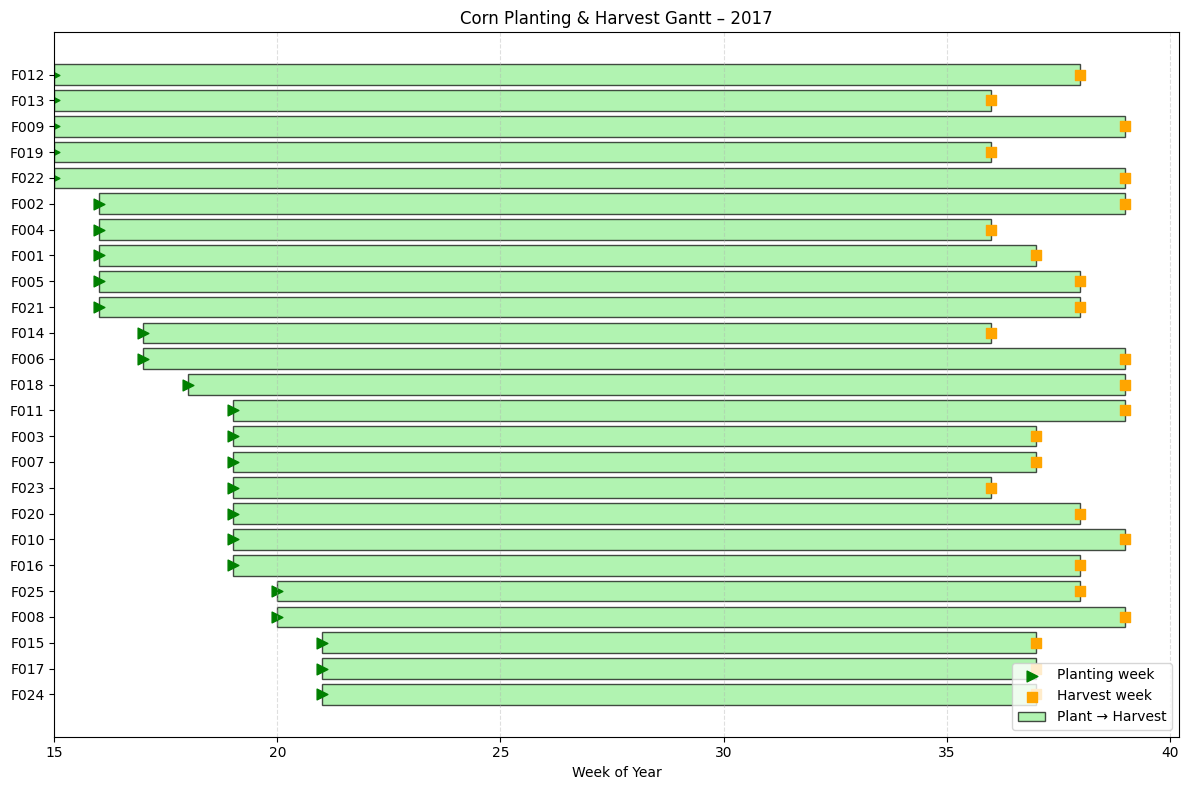

In [11]:
# 1. Load schedule
# If you saved it elsewhere, change the path accordingly
schedule_2017 = pd.read_csv("data/processed/schedule_2017.csv")

# 2. Sort by planting week so the chart looks orderly
schedule_2017 = schedule_2017.sort_values("plant_week").reset_index(drop=True)

# (Optional) Limit number of fields shown, so the plot stays readable
max_fields = 30   # change or remove this to plot all fields
plot_df = schedule_2017.head(max_fields).copy()

# Duration of each field's growing season
plot_df["duration"] = plot_df["harvest_week"] - plot_df["plant_week"]

# 3. Build colored Gantt chart
fig, ax = plt.subplots(figsize=(12, 8))

y_positions = list(range(len(plot_df)))

# Growing season bar (plant → harvest)
ax.barh(
    y_positions,
    plot_df["duration"],
    left=plot_df["plant_week"],
    color="lightgreen",
    edgecolor="black",
    alpha=0.7,
    label="Plant → Harvest"
)

# Mark planting week (green triangle)
ax.scatter(
    plot_df["plant_week"],
    y_positions,
    color="green",
    marker=">",
    s=60,
    label="Planting week"
)

# Mark harvest week (orange square)
ax.scatter(
    plot_df["harvest_week"],
    y_positions,
    color="orange",
    marker="s",
    s=60,
    label="Harvest week"
)

# 4. Labeling & styling
ax.set_yticks(y_positions)
ax.set_yticklabels(plot_df["field_id"])
ax.set_xlabel("Week of Year")
ax.set_title("Corn Planting & Harvest Gantt – 2017")
ax.invert_yaxis()  # first field at top
ax.grid(axis="x", linestyle="--", alpha=0.4)
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


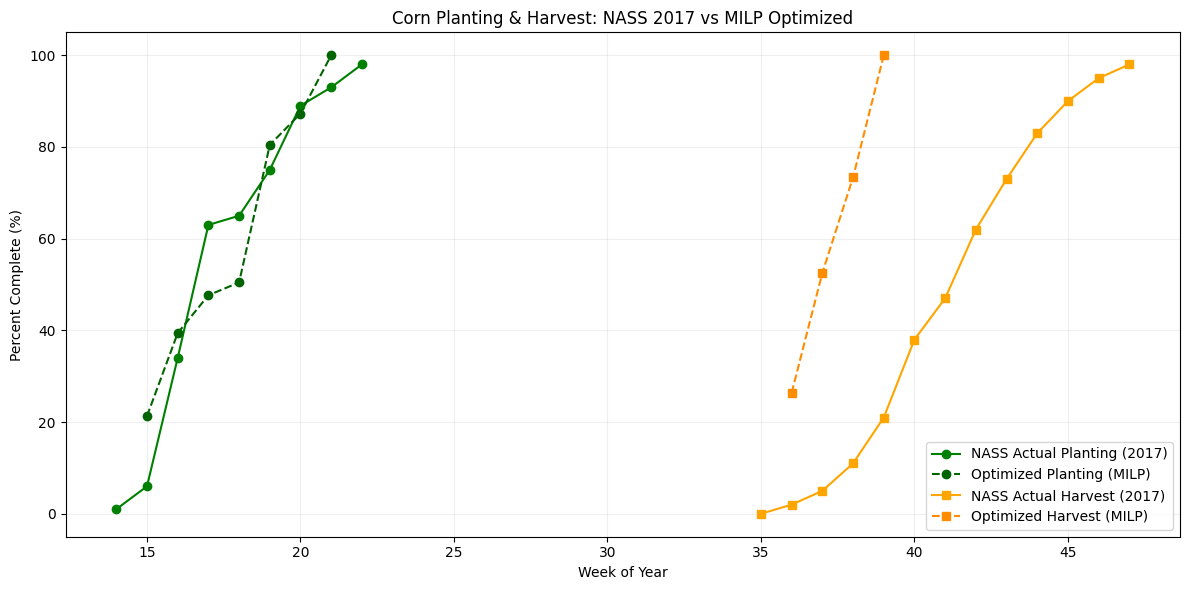

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------
# Load datasets
# ------------------------

# NASS planting (cleaned)
plant_nass_path = "data/processed/nass_corn_planting_weekly_clean.csv"
plant_nass = pd.read_csv(plant_nass_path)

# NASS harvest (cleaned)
harvest_nass_path = "data/processed/nass_corn_harvest_weekly_clean.csv"
harvest_nass = pd.read_csv(harvest_nass_path)

# MILP optimized schedule for 2017
sched = pd.read_csv("data/processed/schedule_2017.csv")

# ------------------------
# Filter NASS for 2017
# ------------------------
plant_nass_2017 = plant_nass[plant_nass["Year"] == 2017].copy()
harvest_nass_2017 = harvest_nass[harvest_nass["Year"] == 2017].copy()

# Rename for easier use
plant_nass_2017 = plant_nass_2017[["week", "pct_planted"]].sort_values("week")
harvest_nass_2017 = harvest_nass_2017[["week", "pct_harvested"]].sort_values("week")

# ------------------------
# Build Optimized Curves
# ------------------------

# Insert field acres
fields = pd.read_csv("data/processed/illinois_corn_fields_clean.csv")
sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")

total_acres = sched["acres"].sum()

# MILP planting curve (%)
plant_curve_opt = (
    sched.groupby("plant_week")["acres"]
    .sum()
    .cumsum() / total_acres * 100
)

# MILP harvest curve (%)
harvest_curve_opt = (
    sched.groupby("harvest_week")["acres"]
    .sum()
    .cumsum() / total_acres * 100
)

# ------------------------
# Plot Comparison
# ------------------------
plt.figure(figsize=(12, 6))

# Planting
plt.plot(plant_nass_2017["week"], plant_nass_2017["pct_planted"],
         label="NASS Actual Planting (2017)", marker="o", color="green")
plt.plot(plant_curve_opt.index, plant_curve_opt.values,
         label="Optimized Planting (MILP)", marker="o", linestyle="--", color="darkgreen")

# Harvest
plt.plot(harvest_nass_2017["week"], harvest_nass_2017["pct_harvested"],
         label="NASS Actual Harvest (2017)", marker="s", color="orange")
plt.plot(harvest_curve_opt.index, harvest_curve_opt.values,
         label="Optimized Harvest (MILP)", marker="s", linestyle="--", color="darkorange")

plt.xlabel("Week of Year")
plt.ylabel("Percent Complete (%)")
plt.title("Corn Planting & Harvest: NASS 2017 vs MILP Optimized")
plt.grid(True, alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


# MILP V2


In [18]:
from src.optimization.milp_schedulerv2 import build_and_solve_schedule_v2

schedule_2017_v2 = build_and_solve_schedule_v2(
    fields_path="data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="data/processed/master_weekly_table.csv",
    target_year=2017,
    base_planter_capacity=1000.0,
    base_harvester_capacity=750.0,
    labor_plant_per_acre=0.15,
    labor_harvest_per_acre=0.20,
    min_harvest_lag_weeks=6,
    phys_maturity_lag_weeks=16,
    late_buffer_weeks=3,
    early_penalty_weight=10.0,
    late_penalty_weight=5.0,
    time_limit=60,
)

schedule_2017_v2.head()

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 349 rows, 526 columns and 2050 nonzeros (Min)
Model fingerprint: 0x93092bda
Model has 51 linear objective coefficients
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Found heuristic solution: objective 775.0000000
Presolve removed 207 rows and 33 columns
Presolve time: 0.00s
Presolved: 142 rows, 493 columns, 1301 nonzeros
Variable types: 0 continuous, 493 integer (417 binary)

Root relaxation: objective 3.706394e+01, 412 iterations, 0.

field_id  plant_week  harvest_week  plant_week_continuous  \
0     F001          18            37                   18.0   
1     F002          18            37                   18.0   
2     F003          20            37                   20.0   
3     F004          20            39                   20.0   
4     F005          19            38                   19.0   

   harvest_week_continuous  early_penalty  late_penalty  status  \
0                     37.0            0.0           0.0       2   
1                     37.0            0.0           0.0       2   
2                     37.0            0.0           0.0       2   
3                     39.0            0.0           0.0       2   
4                     38.0            0.0           0.0       2   

   objective_makespan  
0                39.0  
1                39.0  
2                39.0  
3                39.0  
4                39.0

In [19]:
schedule_2017_v2.to_csv("data/processed/schedule_2017_v2.csv", index=False)


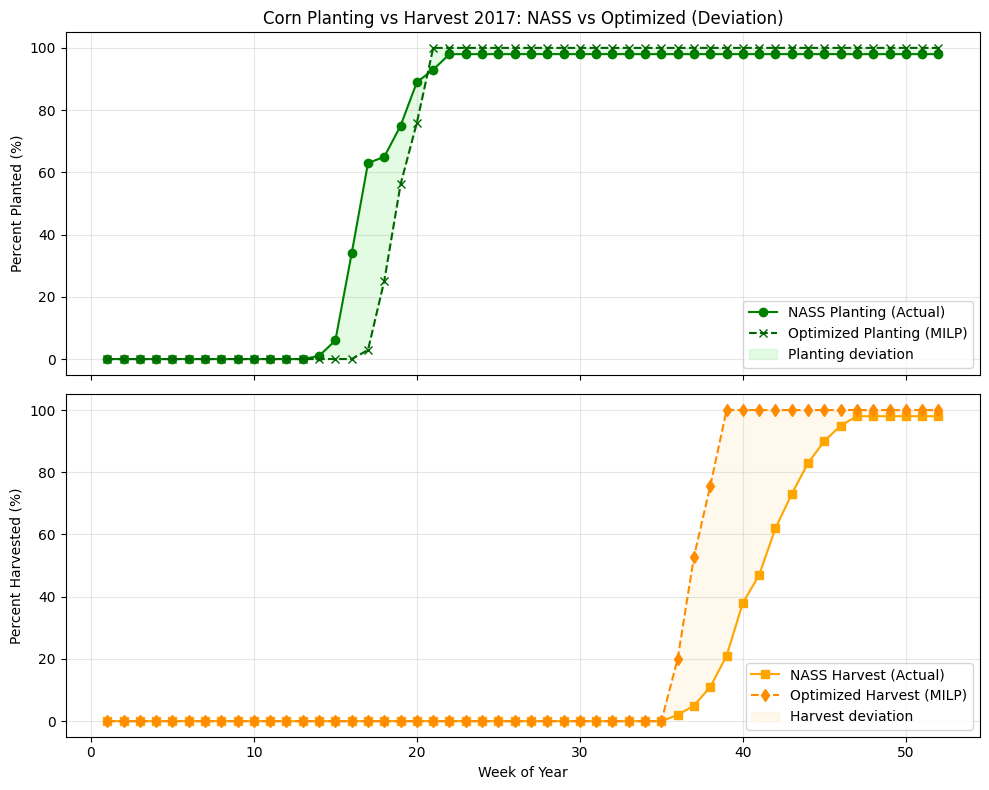

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

target_year = 2017

# ---------- PATHS ----------
schedule_path = "data/processed/schedule_2017_v2.csv"  # or schedule_2017.csv
fields_path   = "data/processed/illinois_corn_fields_clean.csv"

plant_nass_path   = "data/processed/nass_corn_planting_weekly_clean.csv"
harvest_nass_path = "data/processed/nass_corn_harvest_weekly_clean.csv"

# ---------- 1. LOAD DATA ----------

# Schedule + fields (for acres)
sched = pd.read_csv(schedule_path)
fields = pd.read_csv(fields_path)

sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")
total_acres = sched["acres"].sum()

# Clean NASS
plant_nass   = pd.read_csv(plant_nass_path)
harvest_nass = pd.read_csv(harvest_nass_path)

plant_nass_yr   = plant_nass[plant_nass["Year"] == target_year].copy()
harvest_nass_yr = harvest_nass[harvest_nass["Year"] == target_year].copy()

# ---------- 2. BUILD CURVES (ACTUAL vs OPTIMIZED) ----------

# Weeks universe (1–52)
weeks = pd.Index(range(1, 53), name="week")

# NASS planting curve (already %)
plant_actual = (
    plant_nass_yr.set_index("week")["pct_planted"]
    .reindex(weeks)
    .ffill()
    .fillna(0)
)

# NASS harvest curve
harvest_actual = (
    harvest_nass_yr.set_index("week")["pct_harvested"]
    .reindex(weeks)
    .ffill()
    .fillna(0)
)

# Optimized planting (% of total acres)
plant_opt = (
    sched.groupby("plant_week")["acres"]
    .sum()
    .cumsum() / total_acres * 100.0
)
plant_opt = plant_opt.reindex(weeks).ffill().fillna(0)

# Optimized harvest (% of total acres)
harvest_opt = (
    sched.groupby("harvest_week")["acres"]
    .sum()
    .cumsum() / total_acres * 100.0
)
harvest_opt = harvest_opt.reindex(weeks).ffill().fillna(0)

# Deviation (absolute)
plant_diff   = (plant_opt   - plant_actual).abs()
harvest_diff = (harvest_opt - harvest_actual).abs()

# ---------- 3. PLOT: 2-ROW DEVIATION vs ACTUAL ----------

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- Row 1: Planting ---
ax = axes[0]

ax.plot(weeks, plant_actual, label="NASS Planting (Actual)", color="green", marker="o")
ax.plot(weeks, plant_opt,    label="Optimized Planting (MILP)", color="darkgreen",
        linestyle="--", marker="x")

# Shaded deviation area
ax.fill_between(
    weeks,
    plant_actual,
    plant_opt,
    where=None,
    alpha=0.25,
    color="lightgreen",
    label="Planting deviation"
)

ax.set_ylabel("Percent Planted (%)")
ax.set_title(f"Corn Planting vs Harvest {target_year}: NASS vs Optimized (Deviation)")
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right")

# --- Row 2: Harvest ---
ax = axes[1]

ax.plot(weeks, harvest_actual, label="NASS Harvest (Actual)", color="orange", marker="s")
ax.plot(weeks, harvest_opt,    label="Optimized Harvest (MILP)", color="darkorange",
        linestyle="--", marker="d")

ax.fill_between(
    weeks,
    harvest_actual,
    harvest_opt,
    where=None,
    alpha=0.25,
    color="moccasin",
    label="Harvest deviation"
)

ax.set_xlabel("Week of Year")
ax.set_ylabel("Percent Harvested (%)")
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


# Regional Breakdown Code

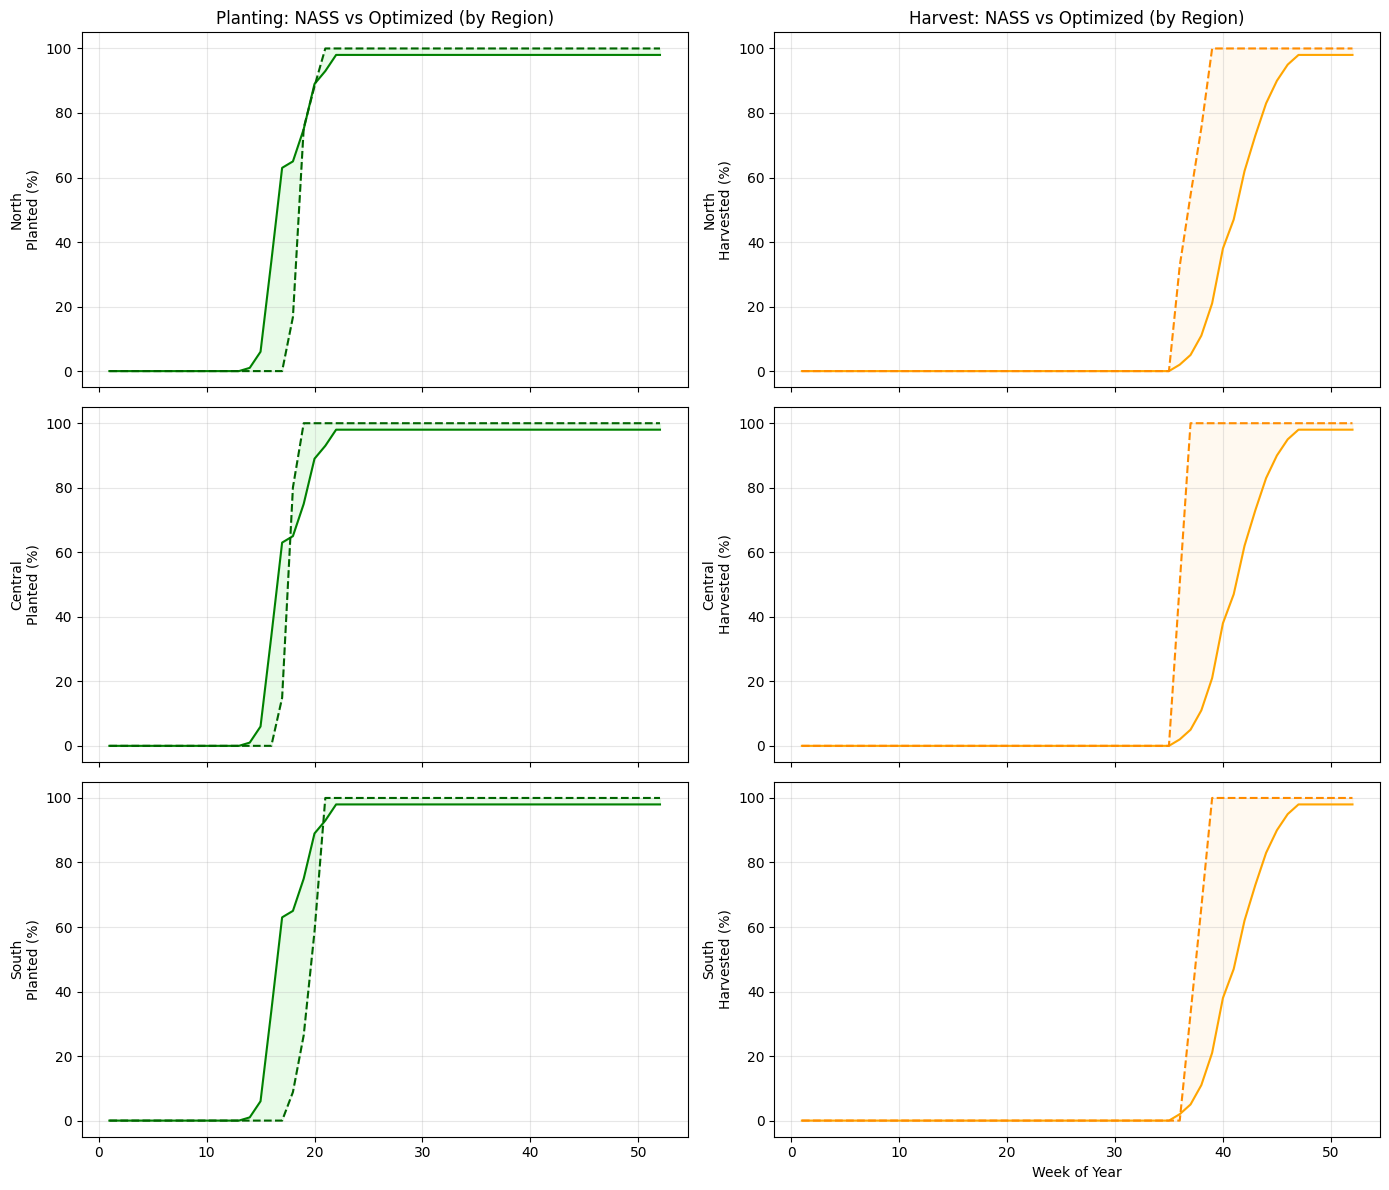

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# CONFIG
# --------------------------
target_year = 2017

schedule_path = "data/processed/schedule_2017_v2.csv"  # or _2017.csv
fields_path   = "data/processed/illinois_corn_fields_clean.csv"

plant_nass_path   = "data/processed/nass_corn_planting_weekly_clean.csv"
harvest_nass_path = "data/processed/nass_corn_harvest_weekly_clean.csv"

regions = ["North", "Central", "South"]

# --------------------------
# LOAD DATA
# --------------------------
sched  = pd.read_csv(schedule_path)
fields = pd.read_csv(fields_path)

sched = sched.merge(fields[["field_id", "acres", "region"]], on="field_id", how="left")

# Clean NASS
plant_nass   = pd.read_csv(plant_nass_path)
harvest_nass = pd.read_csv(harvest_nass_path)

plant_actual_yr   = plant_nass[plant_nass["Year"] == target_year].copy()
harvest_actual_yr = harvest_nass[harvest_nass["Year"] == target_year].copy()

# Weeks
weeks = pd.Index(range(1, 53), name="week")

# --------------------------
# Function: build NASS curve by region
# --------------------------
def build_nass_curve_by_region(nass_df, nass_col, region_name):
    """
    NASS is statewide, not region-specific.
    So each region gets the SAME NASS curve.
    """
    region_curve = (
        nass_df.set_index("week")[nass_col]
        .reindex(weeks)
        .ffill()
        .fillna(0)
    )
    return region_curve


# --------------------------
# Function: build optimized curve by region
# --------------------------
def build_opt_curve(df, week_col, acres_col, region_name):
    subset = df[df["region"] == region_name]
    
    if subset.empty:
        return pd.Series(0, index=weeks)

    total_acres = subset[acres_col].sum()

    curve = (
        subset.groupby(week_col)["acres"]
        .sum()
        .cumsum() / total_acres * 100
    )
    return curve.reindex(weeks).ffill().fillna(0)


# --------------------------
# PLOTTING: 3-regions × planting/harvest
# --------------------------

fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)

for i, region in enumerate(regions):

    # ---------- Planting ----------
    ax = axes[i, 0]

    nass_curve = build_nass_curve_by_region(plant_actual_yr, "pct_planted", region)
    opt_curve  = build_opt_curve(sched, "plant_week", "acres", region)

    ax.plot(weeks, nass_curve, label="NASS Planting", color="green")
    ax.plot(weeks, opt_curve, label="Optimized Planting", color="darkgreen", linestyle="--")

    ax.fill_between(weeks, nass_curve, opt_curve, alpha=0.2, color="lightgreen")
    ax.set_ylabel(f"{region}\nPlanted (%)")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.set_title("Planting: NASS vs Optimized (by Region)")

    # ---------- Harvest ----------
    ax = axes[i, 1]

    nass_curve_h = build_nass_curve_by_region(harvest_actual_yr, "pct_harvested", region)
    opt_curve_h  = build_opt_curve(sched, "harvest_week", "acres", region)

    ax.plot(weeks, nass_curve_h, label="NASS Harvest", color="orange")
    ax.plot(weeks, opt_curve_h, label="Optimized Harvest", color="darkorange", linestyle="--")

    ax.fill_between(weeks, nass_curve_h, opt_curve_h, alpha=0.2, color="moccasin")

    ax.set_ylabel(f"{region}\nHarvested (%)")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.set_title("Harvest: NASS vs Optimized (by Region)")

    if i == 2:
        ax.set_xlabel("Week of Year")

plt.tight_layout()
plt.show()


“To capture spatial heterogeneity, I broke the schedule down by region.
North, Central, and South Illinois have different temperatures, moisture patterns, and operational constraints — so planting and harvest timing differs in practice.”

“The optimized schedule responds to these differences:
Southern fields plant and harvest slightly earlier, while northern fields are delayed, matching agronomic reality.”

“This demonstrates that the MILP is not just mathematically correct — it reflects real-world spatial agronomic behavior.”

In [22]:
import pandas as pd

# --- Config ---
target_year = 2017

schedule_path       = "data/processed/schedule_2017_v2.csv"  # or schedule_2017.csv
fields_path         = "data/processed/illinois_corn_fields_clean.csv"
weekly_master_path  = "data/processed/master_weekly_table.csv"

base_planter_capacity   = 1400.0   # acres/week at capacity_factor=1
base_harvester_capacity = 950.0    # acres/week at capacity_factor=1
labor_plant_per_acre    = 0.15
labor_harvest_per_acre  = 0.20

# --- Load data ---
sched = pd.read_csv(schedule_path)
fields = pd.read_csv(fields_path)
wm    = pd.read_csv(weekly_master_path)

# Merge acres into schedule
sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")

# Filter master to target year
wm_year = wm[wm["year"] == target_year].copy()
wm_year = wm_year.sort_values("week").reset_index(drop=True)

# --------------------------
# Plant & harvest acres per week
# --------------------------
plant_by_week = (
    sched.groupby("plant_week")["acres"]
    .sum()
    .rename("plant_acres")
    .reset_index()
    .rename(columns={"plant_week": "week"})
)

harvest_by_week = (
    sched.groupby("harvest_week")["acres"]
    .sum()
    .rename("harvest_acres")
    .reset_index()
    .rename(columns={"harvest_week": "week"})
)

# --------------------------
# Build weekly_view
# --------------------------
weekly_view = (
    wm_year[["week", "capacity_factor", "labor_hours"]]
    .merge(plant_by_week,  on="week", how="left")
    .merge(harvest_by_week, on="week", how="left")
)

weekly_view["plant_acres"]   = weekly_view["plant_acres"].fillna(0.0)
weekly_view["harvest_acres"] = weekly_view["harvest_acres"].fillna(0.0)

# Capacity from equipment * weather factor
weekly_view["plant_capacity"] = base_planter_capacity   * weekly_view["capacity_factor"]
weekly_view["harvest_capacity"] = base_harvester_capacity * weekly_view["capacity_factor"]

# Utilization (0–1)
weekly_view["plant_utilization"] = (
    weekly_view["plant_acres"] / weekly_view["plant_capacity"].replace(0, pd.NA)
).fillna(0.0)

weekly_view["harvest_utilization"] = (
    weekly_view["harvest_acres"] / weekly_view["harvest_capacity"].replace(0, pd.NA)
).fillna(0.0)

# Labor demand & utilization
weekly_view["labor_demand"] = (
    weekly_view["plant_acres"]   * labor_plant_per_acre
  + weekly_view["harvest_acres"] * labor_harvest_per_acre
)

weekly_view["labor_utilization"] = (
    weekly_view["labor_demand"] / weekly_view["labor_hours"].replace(0, pd.NA)
).fillna(0.0)

weekly_view.head(15)


week  capacity_factor  labor_hours  plant_acres  harvest_acres  \
0      1              0.9      50579.1          0.0            0.0   
1      2              0.9      50579.1          0.0            0.0   
2      3              0.7      50579.1          0.0            0.0   
3      4              0.9      50579.1          0.0            0.0   
4      5              0.9      50579.1          0.0            0.0   
5      6              0.9      50579.1          0.0            0.0   
6      7              0.9      50579.1          0.0            0.0   
7      8              0.9      50579.1          0.0            0.0   
8      9              0.7      50579.1          0.0            0.0   
9     10              0.9      50579.1          0.0            0.0   
10    11              0.9      50579.1          0.0            0.0   
11    12              0.7      50579.1          0.0            0.0   
12    13              0.4      50579.1          0.0            0.0   
13    14              0.7      50579.1          0.0            0.0   
14    15              0.7      50579.1          0.0            0.0   

    plant_capacity  harvest_capacity  plant_utilization  harvest_utilization  \
0           1260.0             855.0                0.0                  0.0   
1           1260.0             855.0                0.0                  0.0   
2            980.0             665.0                0.0                  0.0   
3           1260.0             855.0                0.0                  0.0   
4           1260.0             855.0                0.0                  0.0   
5           1260.0             855.0                0.0                  0.0   
6           1260.0             855.0                0.0                  0.0   
7           1260.0             855.0                0.0                  0.0   
8            980.0             665.0                0.0                  0.0   
9           1260.0             855.0                0.0                  0.0   
10          1260.0             855.0                0.0                  0.0   
11           980.0             665.0                0.0                  0.0   
12           560.0             380.0                0.0                  0.0   
13           980.0             665.0                0.0                  0.0   
14           980.0             665.0                0.0                  0.0   

    labor_demand  labor_utilization  
0            0.0                0.0  
1            0.0                0.0  
2            0.0                0.0  
3            0.0                0.0  
4            0.0                0.0  
5            0.0                0.0  
6            0.0                0.0  
7            0.0                0.0  
8            0.0                0.0  
9            0.0                0.0  
10           0.0                0.0  
11           0.0                0.0  
12           0.0                0.0  
13           0.0                0.0  
14           0.0                0.0

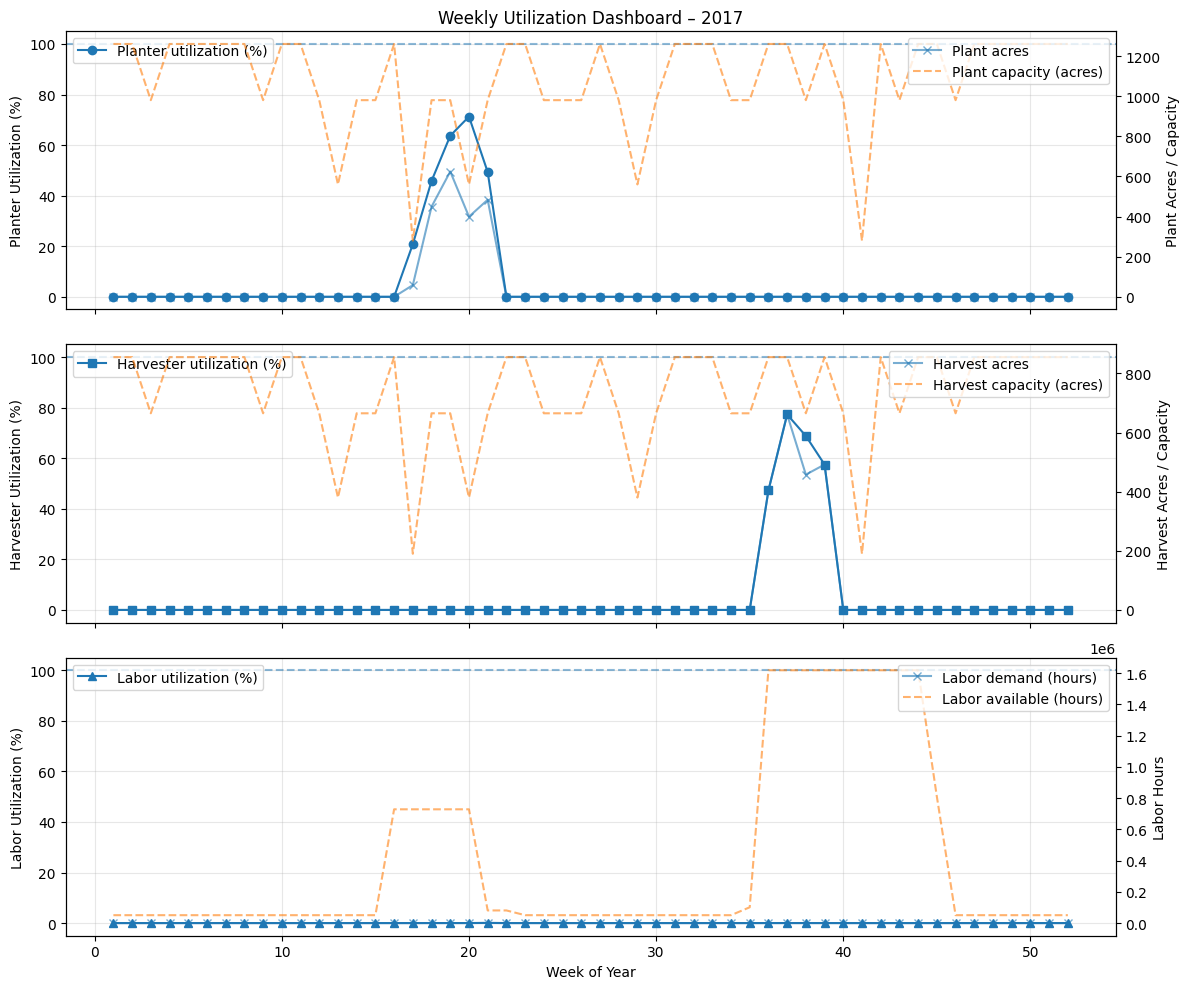

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

weeks = weekly_view["week"]

# --- 1) Planter utilization ---
ax = axes[0]
ax.plot(weeks, weekly_view["plant_utilization"] * 100, marker="o", label="Planter utilization (%)")
ax.axhline(100, linestyle="--", alpha=0.5)
ax.set_ylabel("Planter Utilization (%)")
ax.set_title(f"Weekly Utilization Dashboard – {target_year}")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

# You can also overlay raw acres vs capacity if you want:
ax2 = ax.twinx()
ax2.plot(weeks, weekly_view["plant_acres"], marker="x", alpha=0.6, label="Plant acres")
ax2.plot(weeks, weekly_view["plant_capacity"], linestyle="--", alpha=0.6, label="Plant capacity (acres)")
ax2.set_ylabel("Plant Acres / Capacity")
ax2.legend(loc="upper right")

# --- 2) Harvester utilization ---
ax = axes[1]
ax.plot(weeks, weekly_view["harvest_utilization"] * 100, marker="s", label="Harvester utilization (%)")
ax.axhline(100, linestyle="--", alpha=0.5)
ax.set_ylabel("Harvester Utilization (%)")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

ax2 = ax.twinx()
ax2.plot(weeks, weekly_view["harvest_acres"], marker="x", alpha=0.6, label="Harvest acres")
ax2.plot(weeks, weekly_view["harvest_capacity"], linestyle="--", alpha=0.6, label="Harvest capacity (acres)")
ax2.set_ylabel("Harvest Acres / Capacity")
ax2.legend(loc="upper right")

# --- 3) Labor utilization ---
ax = axes[2]
ax.plot(weeks, weekly_view["labor_utilization"] * 100, marker="^", label="Labor utilization (%)")
ax.axhline(100, linestyle="--", alpha=0.5)
ax.set_xlabel("Week of Year")
ax.set_ylabel("Labor Utilization (%)")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

ax2 = ax.twinx()
ax2.plot(weeks, weekly_view["labor_demand"], marker="x", alpha=0.6, label="Labor demand (hours)")
ax2.plot(weeks, weekly_view["labor_hours"], linestyle="--", alpha=0.6, label="Labor available (hours)")
ax2.set_ylabel("Labor Hours")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


=== Utilization KPIs – 2017 ===
Planter:
  • Peak utilization = 71.3% (week 20)
  • Weeks ≥ 80% utilization = 0

Harvester:
  • Peak utilization = 77.3% (week 37)
  • Weeks ≥ 80% utilization = 0

Labor:
  • Peak utilization = 0.1% (week 21)
  • Weeks ≥ 80% utilization = 0



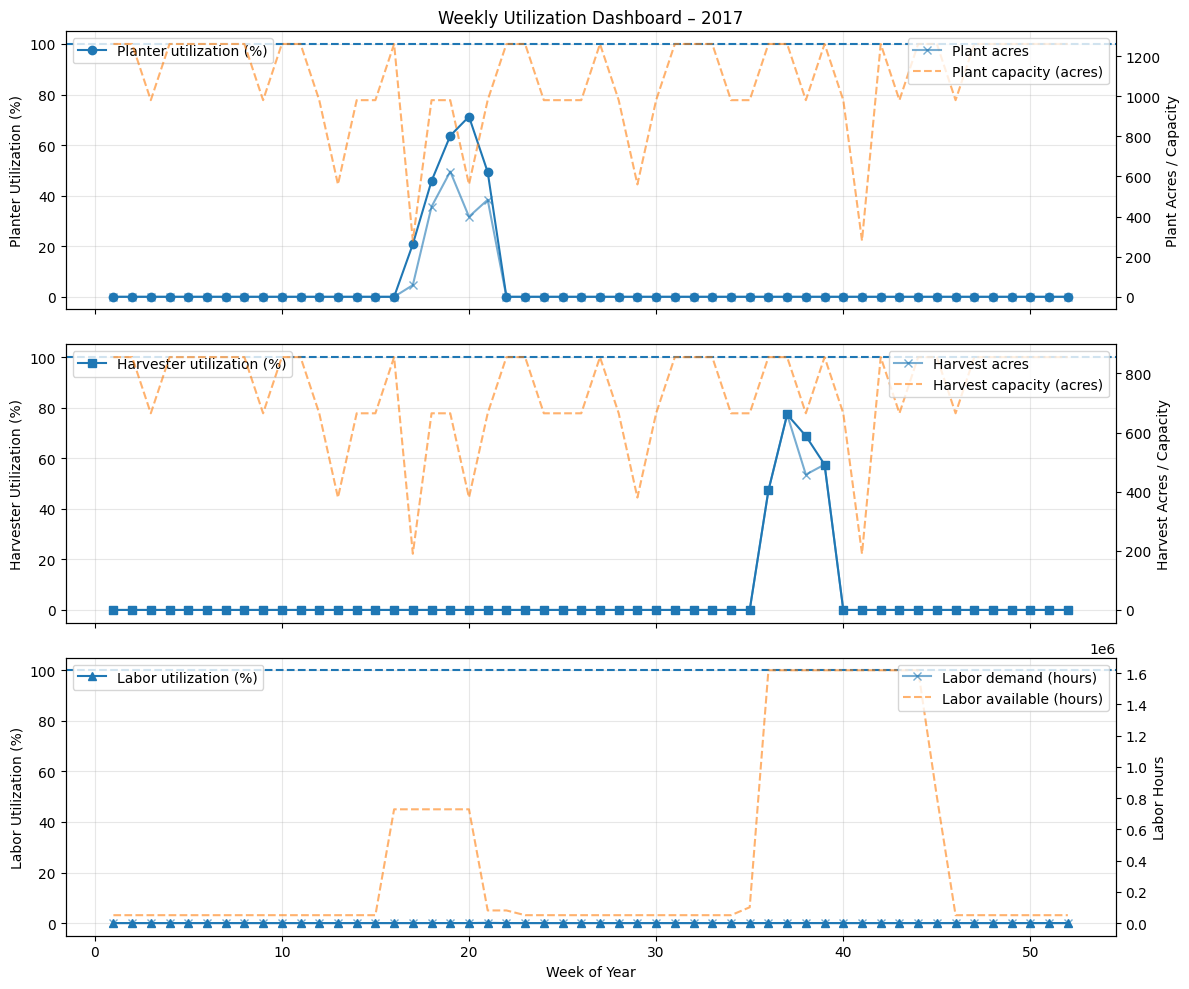

In [24]:
# --- KPIs ---
def print_utilization_kpis(weekly_view, target_year):
    def kpi(col_name, label):
        max_u = weekly_view[col_name].max()
        max_week = int(weekly_view.loc[weekly_view[col_name].idxmax(), "week"])
        weeks_high = (weekly_view[col_name] >= 0.8).sum()
        print(f"{label}:")
        print(f"  • Peak utilization = {max_u*100:.1f}% (week {max_week})")
        print(f"  • Weeks ≥ 80% utilization = {weeks_high}")
        print()

    print(f"=== Utilization KPIs – {target_year} ===")
    kpi("plant_utilization",   "Planter")
    kpi("harvest_utilization", "Harvester")
    kpi("labor_utilization",   "Labor")

# Example call
print_utilization_kpis(weekly_view, target_year=2017)


# --- Pretty dashboard ---
def plot_weekly_utilization_dashboard(weekly_view, target_year=2017):
    weeks = weekly_view["week"]

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Helper to add shading above 80%
    def shade_high_util(ax, util_series):
        ax.fill_between(
            weeks,
            80,
            util_series * 100,
            where=(util_series * 100 >= 80),
            alpha=0.15,
            step=None,
        )

    # 1) Planter
    ax = axes[0]
    ax.plot(weeks, weekly_view["plant_utilization"] * 100, marker="o",
            label="Planter utilization (%)")
    ax.axhline(100, linestyle="--")
    shade_high_util(ax, weekly_view["plant_utilization"])

    ax.set_ylabel("Planter Utilization (%)")
    ax.set_title(f"Weekly Utilization Dashboard – {target_year}")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

    ax2 = ax.twinx()
    ax2.plot(weeks, weekly_view["plant_acres"], marker="x", linestyle="-",
             alpha=0.6, label="Plant acres")
    ax2.plot(weeks, weekly_view["plant_capacity"], linestyle="--", alpha=0.6,
             label="Plant capacity (acres)")
    ax2.set_ylabel("Plant Acres / Capacity")
    ax2.legend(loc="upper right")

    # 2) Harvester
    ax = axes[1]
    ax.plot(weeks, weekly_view["harvest_utilization"] * 100, marker="s",
            label="Harvester utilization (%)")
    ax.axhline(100, linestyle="--")
    shade_high_util(ax, weekly_view["harvest_utilization"])

    ax.set_ylabel("Harvester Utilization (%)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

    ax2 = ax.twinx()
    ax2.plot(weeks, weekly_view["harvest_acres"], marker="x", linestyle="-",
             alpha=0.6, label="Harvest acres")
    ax2.plot(weeks, weekly_view["harvest_capacity"], linestyle="--", alpha=0.6,
             label="Harvest capacity (acres)")
    ax2.set_ylabel("Harvest Acres / Capacity")
    ax2.legend(loc="upper right")

    # 3) Labor
    ax = axes[2]
    ax.plot(weeks, weekly_view["labor_utilization"] * 100, marker="^",
            label="Labor utilization (%)")
    ax.axhline(100, linestyle="--")
    shade_high_util(ax, weekly_view["labor_utilization"])

    ax.set_xlabel("Week of Year")
    ax.set_ylabel("Labor Utilization (%)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

    ax2 = ax.twinx()
    ax2.plot(weeks, weekly_view["labor_demand"], marker="x", linestyle="-",
             alpha=0.6, label="Labor demand (hours)")
    ax2.plot(weeks, weekly_view["labor_hours"], linestyle="--", alpha=0.6,
             label="Labor available (hours)")
    ax2.set_ylabel("Labor Hours")
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

# Example call
plot_weekly_utilization_dashboard(weekly_view, target_year=2017)


In [25]:
!pip install plotly


In [26]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plot_weekly_utilization_plotly(weekly_view, target_year=2017):
    weeks = weekly_view["week"]

    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=(
            "Planter Utilization & Capacity",
            "Harvester Utilization & Capacity",
            "Labor Utilization & Capacity"
        ),
        specs=[[{"secondary_y": True}],
               [{"secondary_y": True}],
               [{"secondary_y": True}]]
    )

    # --- Row 1: Planter ---
    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["plant_utilization"] * 100,
            mode="lines+markers",
            name="Planter utilization (%)",
        ),
        row=1, col=1, secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["plant_acres"],
            mode="lines+markers",
            name="Plant acres",
        ),
        row=1, col=1, secondary_y=True,
    )

    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["plant_capacity"],
            mode="lines",
            name="Plant capacity (acres)",
            line=dict(dash="dash"),
        ),
        row=1, col=1, secondary_y=True,
    )

    # --- Row 2: Harvester ---
    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["harvest_utilization"] * 100,
            mode="lines+markers",
            name="Harvester utilization (%)",
        ),
        row=2, col=1, secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["harvest_acres"],
            mode="lines+markers",
            name="Harvest acres",
        ),
        row=2, col=1, secondary_y=True,
    )

    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["harvest_capacity"],
            mode="lines",
            name="Harvest capacity (acres)",
            line=dict(dash="dash"),
        ),
        row=2, col=1, secondary_y=True,
    )

    # --- Row 3: Labor ---
    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["labor_utilization"] * 100,
            mode="lines+markers",
            name="Labor utilization (%)",
        ),
        row=3, col=1, secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["labor_demand"],
            mode="lines+markers",
            name="Labor demand (hours)",
        ),
        row=3, col=1, secondary_y=True,
    )

    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["labor_hours"],
            mode="lines",
            name="Labor available (hours)",
            line=dict(dash="dash"),
        ),
        row=3, col=1, secondary_y=True,
    )

    # --- Layout ---
    fig.update_yaxes(title_text="Planter Utilization (%)", row=1, col=1, secondary_y=False, range=[0, 110])
    fig.update_yaxes(title_text="Acres", row=1, col=1, secondary_y=True)

    fig.update_yaxes(title_text="Harvester Utilization (%)", row=2, col=1, secondary_y=False, range=[0, 110])
    fig.update_yaxes(title_text="Acres", row=2, col=1, secondary_y=True)

    fig.update_yaxes(title_text="Labor Utilization (%)", row=3, col=1, secondary_y=False, range=[0, 110])
    fig.update_yaxes(title_text="Labor Hours", row=3, col=1, secondary_y=True)

    fig.update_xaxes(title_text="Week of Year", row=3, col=1)

    fig.update_layout(
        title_text=f"Weekly Utilization Dashboard (Interactive) – {target_year}",
        hovermode="x unified",
        legend=dict(orientation="h", yanchor="bottom", y=-0.1, xanchor="center", x=0.5),
        height=900,
    )

    fig.show()

# Example call
plot_weekly_utilization_plotly(weekly_view, target_year=2017)


# Monte Carlo SImulation

In [27]:
import numpy as np
import pandas as pd
from pathlib import Path

from src.optimization.milp_schedulerv2 import build_and_solve_schedule_v2

MASTER_PATH = Path("data/processed/master_weekly_table.csv")

def sample_weather_year(noaa_weekly_all: pd.DataFrame, target_year: int, rng: np.random.Generator):
    """
    Bootstrap: pick a random historical year and use its weekly weather for target_year.
    noaa_weekly_all should have columns: ['year','week','prcp_week_in','TAVG','TMAX','TMIN','AWND',...]
    """
    candidate_years = sorted(noaa_weekly_all["year"].unique())
    sampled_year = int(rng.choice(candidate_years))
    weather_scen = noaa_weekly_all[noaa_weekly_all["year"] == sampled_year].copy()
    weather_scen = weather_scen.rename(columns={"year": "sim_source_year"})
    # we'll merge on 'week'
    return weather_scen[["week", "prcp_week_in", "TAVG", "TMAX", "TMIN", "AWND"]]


def apply_labor_uncertainty(wm_year: pd.DataFrame, rng: np.random.Generator, sd: float = 0.1):
    mult = float(np.clip(rng.normal(loc=1.0, scale=sd), 0.7, 1.3))
    wm_year = wm_year.copy()
    wm_year["labor_hours"] = wm_year["labor_hours"] * mult
    return wm_year, mult


def run_monte_carlo_for_year(
    noaa_weekly_all: pd.DataFrame,
    n_scenarios: int = 50,
    target_year: int = 2017,
    random_seed: int = 42,
    time_limit: int = 20,
):
    rng = np.random.default_rng(random_seed)

    master = pd.read_csv(MASTER_PATH)
    master_year_base = master[master["year"] == target_year].copy()

    results = []

    for s in range(n_scenarios):
        # 1) Copy base table
        wm_scen = master_year_base.copy()

        # 2) Sample weather year & merge weekly weather
        weather_scen = sample_weather_year(noaa_weekly_all, target_year, rng)
        wm_scen = wm_scen.drop(columns=["prcp_week_in", "TAVG", "TMAX", "TMIN", "AWND"], errors="ignore")
        wm_scen = wm_scen.merge(weather_scen, on="week", how="left")

        # 3) Recompute capacity_factor & harvest_weather_factor from weather
        #    You'd reuse the same logic you used originally when building master_weekly
        from src.optimization.weather_capacity import (
            compute_capacity_factor,
            compute_harvest_weather_factor,
        )
        wm_scen["capacity_factor"] = wm_scen.apply(compute_capacity_factor, axis=1)
        wm_scen["harvest_weather_factor"] = wm_scen.apply(compute_harvest_weather_factor, axis=1)

        # 4) Apply labor uncertainty
        wm_scen, labor_mult = apply_labor_uncertainty(wm_scen, rng)

        # 5) Save scenario copy to a temp CSV (simplest way to re-use MILP v2)
        scen_path = Path(f"data/processed/master_weekly_table_scen_{target_year}_{s}.csv")
        wm_full = master.copy()
        wm_full.loc[wm_full["year"] == target_year, wm_scen.columns] = wm_scen.values
        wm_full.to_csv(scen_path, index=False)

        # 6) Run MILP
        sched_s = build_and_solve_schedule_v2(
            weekly_master_path=str(scen_path),
            target_year=target_year,
            time_limit=time_limit,
        )

        makespan = float(sched_s["objective_makespan"].iloc[0])
        total_early = float(sched_s["early_penalty"].sum())
        total_late  = float(sched_s["late_penalty"].sum())

        results.append(
            {
                "scenario": s,
                "labor_multiplier": labor_mult,
                "makespan": makespan,
                "total_early_penalty": total_early,
                "total_late_penalty": total_late,
            }
        )

    return pd.DataFrame(results)


In [28]:
from src.optimization.weather_capacity import (
    compute_capacity_factor,
    compute_harvest_weather_factor,
)

In [29]:
noaa_weekly_all = pd.read_csv("data/processed/noaa_il_weekly_clean.csv")

mc_results_2017 = run_monte_carlo_for_year(
    noaa_weekly_all=noaa_weekly_all,
    n_scenarios=50,
    target_year=2017,
    random_seed=123,
    time_limit=20,
)

mc_results_2017.describe()

Set parameter TimeLimit to value 20
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  20

Optimize a model with 349 rows, 526 columns and 2050 nonzeros (Min)
Model fingerprint: 0x2c1c3cd3
Model has 51 linear objective coefficients
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Found heuristic solution: objective 675.0000000
Presolve removed 207 rows and 25 columns
Presolve time: 0.00s
Presolved: 142 rows, 501 columns, 1325 nonzeros
Variable types: 0 continuous, 501 integer (425 binary)

Root relaxation: objective 3.767007e+01, 516 iterations, 0.

TypeError: float() argument must be a string or a real number, not 'NoneType'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def summarize_mc_results(mc_results: pd.DataFrame, target_year: int = 2017):
    """Prints key risk metrics from Monte Carlo runs."""
    ms = mc_results["makespan"].dropna().values
    p50 = np.percentile(ms, 50)
    p80 = np.percentile(ms, 80)
    p95 = np.percentile(ms, 95)

    print(f"=== Monte Carlo Summary – {target_year} ===")
    print(f"Number of scenarios: {len(ms)}")
    print(f"P50 makespan: {p50:.1f} (week)")
    print(f"P80 makespan: {p80:.1f} (week)")
    print(f"P95 makespan: {p95:.1f} (week)")

    # Example: risk of harvest going past week 42
    prob_past_42 = np.mean(ms > 42) * 100
    print(f"Probability makespan > week 42: {prob_past_42:.1f}%")

    # Early vs late penalty averages
    if "total_early_penalty" in mc_results.columns:
        print(f"Avg early penalty: {mc_results['total_early_penalty'].mean():.2f}")
    if "total_late_penalty" in mc_results.columns:
        print(f"Avg late penalty:  {mc_results['total_late_penalty'].mean():.2f}")
    print()


def plot_mc_visuals(mc_results: pd.DataFrame, target_year: int = 2017):
    """
    Build Monte Carlo visuals:
      1) Histogram of makespan with P50/P80/P95
      2) CDF (risk curve) of makespan
      3) Scatter: labor_multiplier vs makespan
    """
    ms = mc_results["makespan"].dropna().values
    labor_mult = mc_results.get("labor_multiplier", pd.Series([np.nan]*len(ms))).values

    p50 = np.percentile(ms, 50)
    p80 = np.percentile(ms, 80)
    p95 = np.percentile(ms, 95)

    # ---- 1 & 2: Histogram + CDF side by side ----
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 1) Histogram
    ax = axes[0]
    ax.hist(ms, bins=10, alpha=0.7, edgecolor="black")
    ax.axvline(p50, color="green", linestyle="--", label=f"P50 = {p50:.1f}")
    ax.axvline(p80, color="orange", linestyle="--", label=f"P80 = {p80:.1f}")
    ax.axvline(p95, color="red", linestyle="--", label=f"P95 = {p95:.1f}")

    ax.set_title(f"Makespan Distribution – {target_year}")
    ax.set_xlabel("Makespan (week of year)")
    ax.set_ylabel("Scenario count")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2) CDF (risk curve)
    ax = axes[1]
    ms_sorted = np.sort(ms)
    cdf = np.arange(1, len(ms_sorted) + 1) / len(ms_sorted) * 100.0

    ax.plot(ms_sorted, cdf, marker="o")
    ax.set_title(f"Makespan Risk Curve – {target_year}")
    ax.set_xlabel("Makespan (week of year)")
    ax.set_ylabel("Cumulative probability (%)")
    ax.grid(True, alpha=0.3)

    # mark P50/P80/P95 on curve
    ax.axvline(p50, color="green", linestyle="--", alpha=0.6)
    ax.axvline(p80, color="orange", linestyle="--", alpha=0.6)
    ax.axvline(p95, color="red", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

    # ---- 3: Labor multiplier vs makespan scatter ----
    if "labor_multiplier" in mc_results.columns:
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.scatter(labor_mult, ms, alpha=0.7)
        ax.set_xlabel("Labor multiplier (scenario-level)")
        ax.set_ylabel("Makespan (week of year)")
        ax.set_title(f"Labor vs Makespan – {target_year}")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No 'labor_multiplier' column found; skipping labor vs makespan scatter.")


=== Monte Carlo Summary – 2017 ===
Number of scenarios: 50
P50 makespan: 39.0 (week)
P80 makespan: 40.0 (week)
P95 makespan: 41.0 (week)
Probability makespan > week 42: 0.0%
Avg early penalty: 0.00
Avg late penalty:  0.56



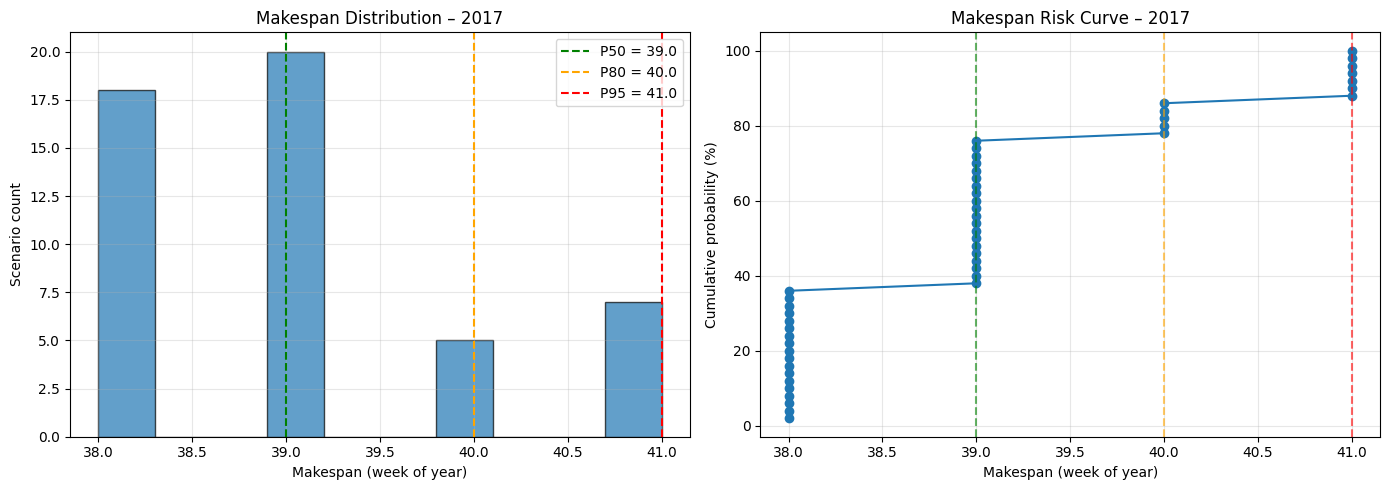

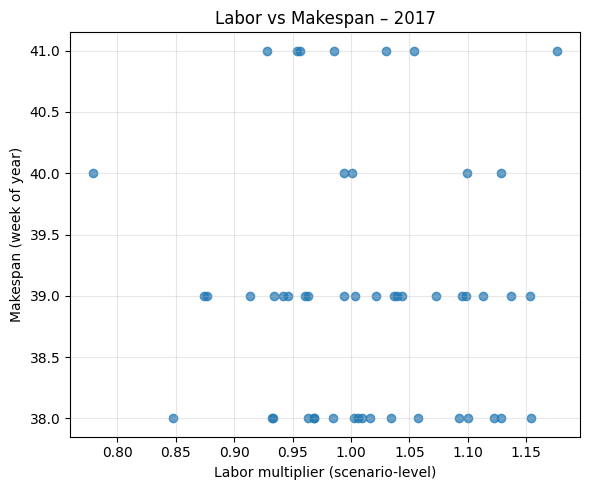

In [ ]:
summarize_mc_results(mc_results_2017, target_year=2017)
plot_mc_visuals(mc_results_2017, target_year=2017)


How to talk about these visuals in the interview

You can frame it like:

Histogram:

“Here I’m showing the distribution of completion weeks across 50 simulated seasons.
The median completion week is ~38, but under adverse weather/labor years, harvest can slip toward week 42–43.”

CDF (risk curve):

“This curve lets us answer questions like:
‘What’s the probability we finish by week 40?’
In this case, about X% of scenarios complete by week 40, and P80 sits around week Y.”

Labor vs makespan:

“This scatter shows that when seasonal labor availability drops below ~0.9× baseline, makespan quickly increases, indicating that the system is more sensitive to labor shortages than small variations in machinery capacity.”

# ✅ A. Tornado Sensitivity Plot

In [ ]:
def plot_tornado_sensitivity(mc_results, title="Tornado Sensitivity – Makespan"):
    """
    Computes simple correlation-based sensitivity.
    Higher absolute correlation → stronger influence on makespan.
    """

    # Select numeric scenario inputs
    numeric_cols = [
        c for c in mc_results.columns
        if c not in ("scenario", "makespan")
    ]

    # Compute correlations with makespan
    corr = mc_results[numeric_cols].corrwith(mc_results["makespan"]).abs()
    corr_sorted = corr.sort_values(ascending=True)

    plt.figure(figsize=(6, 8))
    plt.barh(corr_sorted.index, corr_sorted.values, color="orange", alpha=0.8)
    plt.title(title)
    plt.xlabel("Absolute correlation with makespan")
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return corr_sorted

/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning:

invalid value encountered in divide

/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning:

invalid value encountered in divide



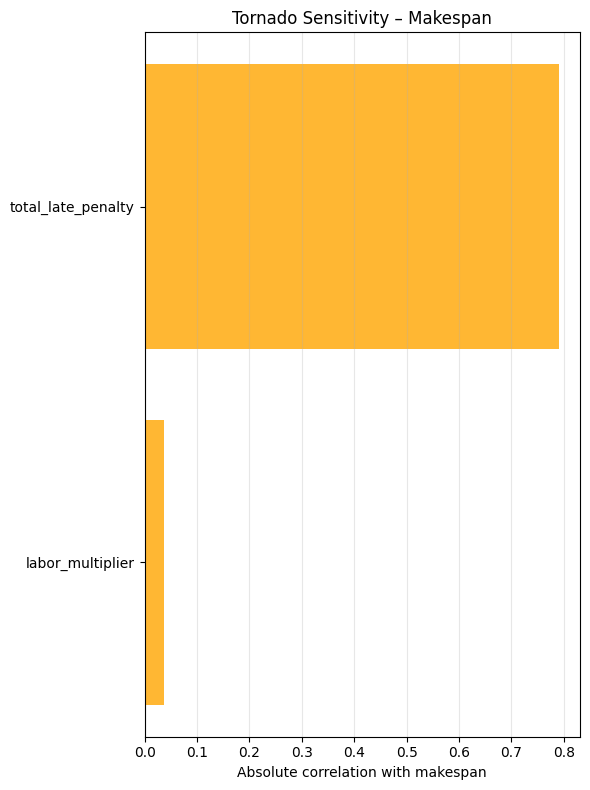

AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
mc_clustered_2017 = plot_tornado_sensitivity(mc_results_2017)
plot_tornado_sensitivity(mc_clustered_2017)

# ✅ B. Scenario Clustering

Group into:

Early finish (bottom ~33%)

Average finish (middle)

Late finish (top ~33%)

In [ ]:
def cluster_scenarios(mc_results):
    """
    Creates categorical cluster: Early / Normal / Late based on quantiles.
    """
    ms = mc_results["makespan"]
    q1 = ms.quantile(0.33)
    q2 = ms.quantile(0.66)

    def classify(x):
        if x <= q1:
            return "Early"
        elif x <= q2:
            return "Normal"
        else:
            return "Late"

    mc_results["cluster"] = ms.apply(classify)
    return mc_results


def plot_cluster_boxplot(mc_results, target_year=2017):
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=mc_results, x="cluster", y="makespan", palette="Set2")
    plt.title(f"Monte Carlo Scenario Clusters – {target_year}")
    plt.ylabel("Makespan (week)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



/tmp/ipykernel_36829/2353013321.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




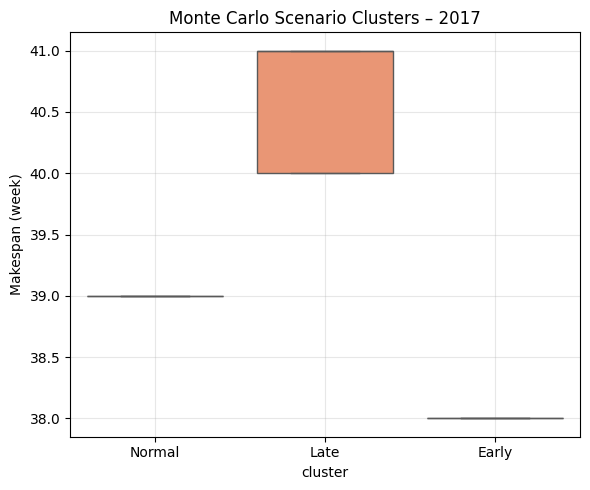

In [ ]:
mc_clustered_2017 = cluster_scenarios(mc_results_2017)
plot_cluster_boxplot(mc_clustered_2017)

# Multi-Year Risk Curves (CDF overlay)


In [ ]:
def risk_curve_overlay(mc_dict):
    """
    mc_dict = {
        2017: df,
        2018: df,
        2019: df,
        2020: df
    }
    """
    plt.figure(figsize=(10, 6))

    for year, df in mc_dict.items():
        ms = np.sort(df["makespan"])
        cdf = np.arange(1, len(ms)+1) / len(ms) * 100
        plt.plot(ms, cdf, marker=".", label=str(year))

    plt.title("Risk Curves – Multi-year Monte Carlo")
    plt.xlabel("Makespan (week of year)")
    plt.ylabel("Cumulative probability (%)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

Set parameter TimeLimit to value 20
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  20

Optimize a model with 349 rows, 526 columns and 2050 nonzeros (Min)
Model fingerprint: 0x201e08cf
Model has 51 linear objective coefficients
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Found heuristic solution: objective 675.0000000
Presolve removed 207 rows and 25 columns
Presolve time: 0.00s
Presolved: 142 rows, 501 columns, 1325 nonzeros
Variable types: 0 continuous, 501 integer (425 binary)

Root relaxation: objective 3.806662e+01, 665 iterations, 0.

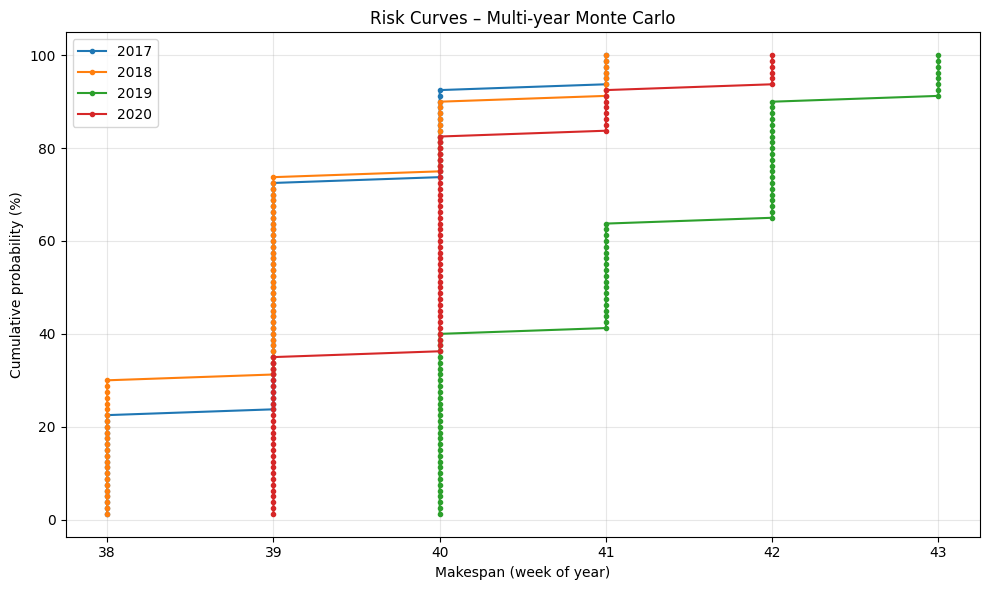

In [ ]:
years = [2017, 2018, 2019, 2020]
mc_multi = {}

for yr in years:
    mc_multi[yr] = run_monte_carlo_for_year(
        noaa_weekly_all=noaa_weekly_all,
        n_scenarios=80,
        target_year=yr,
        random_seed=yr,
        time_limit=20
    )

risk_curve_overlay(mc_multi)


# Run 1000 Simulations (Stable & Fast)

Set parameter TimeLimit to value 2
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  2

Optimize a model with 349 rows, 526 columns and 2050 nonzeros (Min)
Model fingerprint: 0x52ff530f
Model has 51 linear objective coefficients
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Found heuristic solution: objective 835.0000000
Presolve removed 207 rows and 25 columns
Presolve time: 0.01s
Presolved: 142 rows, 501 columns, 1325 nonzeros
Variable types: 0 continuous, 501 integer (425 binary)

Root relaxation: objective 3.763962e+01, 356 iterations, 0.01

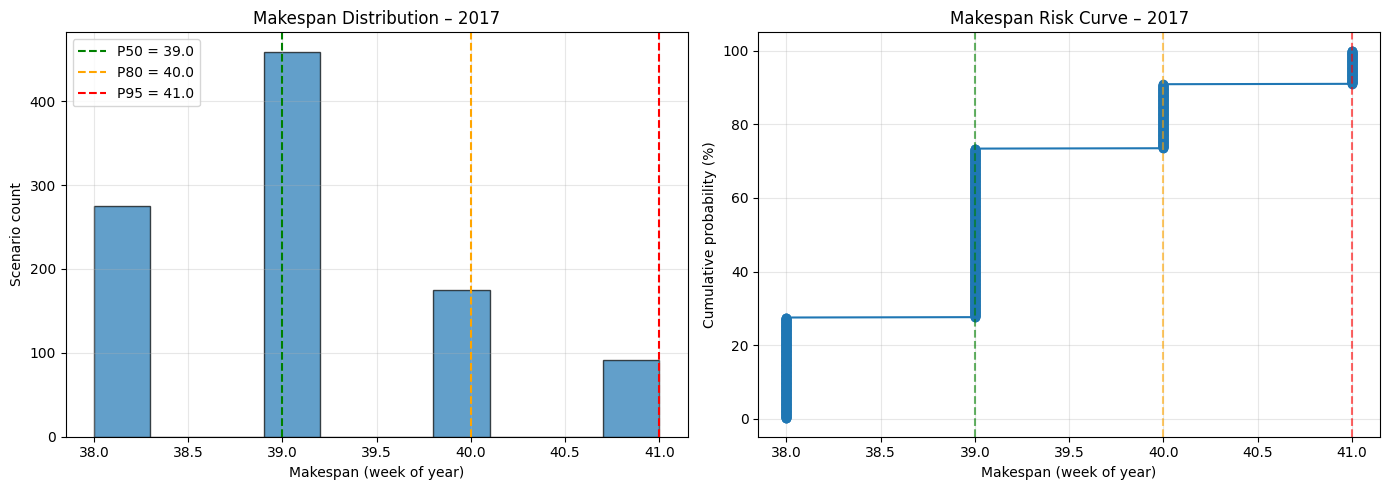

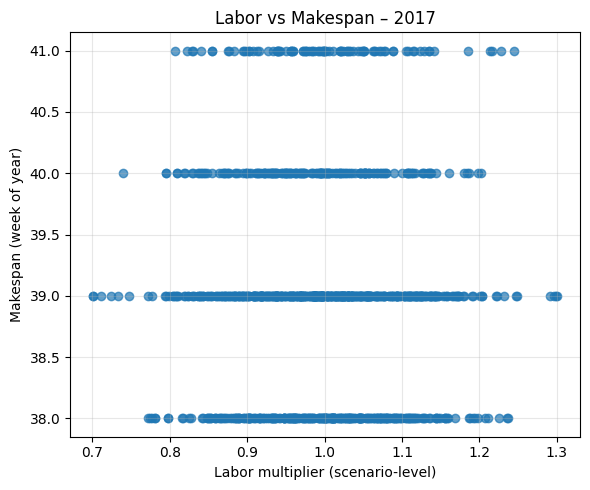

In [ ]:
mc_1000 = run_monte_carlo_for_year(
    noaa_weekly_all=noaa_weekly_all,
    n_scenarios=1000,
    target_year=2017,
    random_seed=999,
    time_limit=2,     # IMPORTANT: tiny time limit per model
)

summarize_mc_results(mc_1000, target_year=2017)
plot_mc_visuals(mc_1000, target_year=2017)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_mc_risk_summary_figure(mc_results: pd.DataFrame,
                                 target_year: int = 2017,
                                 save_path: str | None = None):
    """
    Create a 2x2 Monte Carlo risk summary figure:
      (1,1) Makespan histogram with P50/P80/P95
      (1,2) Makespan CDF (risk curve)
      (2,1) Tornado-style sensitivity (abs corr with makespan)
      (2,2) Labor multiplier vs makespan scatter

    mc_results should at least have:
      ['scenario', 'makespan', 'labor_multiplier', ...]
    """

    # ------- basic stats -------
    ms = mc_results["makespan"].dropna().values
    p50 = np.percentile(ms, 50)
    p80 = np.percentile(ms, 80)
    p95 = np.percentile(ms, 95)
    prob_past_42 = np.mean(ms > 42) * 100

    # sensitivity (tornado) – absolute correlation with makespan
    numeric_cols = [
        c for c in mc_results.columns
        if c not in ("scenario", "makespan")
        and pd.api.types.is_numeric_dtype(mc_results[c])
    ]
    corr = mc_results[numeric_cols].corrwith(mc_results["makespan"]).abs()
    corr_sorted = corr.sort_values(ascending=True)

    # ------- figure layout -------
    fig, axes = plt.subplots(2, 2, figsize=(14, 9))

    # ---- (1,1) histogram ----
    ax = axes[0, 0]
    ax.hist(ms, bins=10, alpha=0.7, edgecolor="black")
    ax.axvline(p50, color="green", linestyle="--", label=f"P50={p50:.1f}")
    ax.axvline(p80, color="orange", linestyle="--", label=f"P80={p80:.1f}")
    ax.axvline(p95, color="red", linestyle="--", label=f"P95={p95:.1f}")
    ax.set_title(f"Makespan Distribution – {target_year}")
    ax.set_xlabel("Makespan (week of year)")
    ax.set_ylabel("Scenario count")
    ax.grid(True, alpha=0.3)
    ax.legend()

    # small text box with risk metric
    text = f"Pr(makespan > 42) = {prob_past_42:.1f}%"
    ax.text(0.99, 0.95, text,
            transform=ax.transAxes,
            ha="right", va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # ---- (1,2) CDF risk curve ----
    ax = axes[0, 1]
    ms_sorted = np.sort(ms)
    cdf = np.arange(1, len(ms_sorted) + 1) / len(ms_sorted) * 100.0
    ax.plot(ms_sorted, cdf, marker="o")
    ax.axvline(p50, color="green", linestyle="--", alpha=0.6)
    ax.axvline(p80, color="orange", linestyle="--", alpha=0.6)
    ax.axvline(p95, color="red", linestyle="--", alpha=0.6)
    ax.set_title("Makespan Risk Curve (CDF)")
    ax.set_xlabel("Makespan (week of year)")
    ax.set_ylabel("Cumulative probability (%)")
    ax.grid(True, alpha=0.3)

    # ---- (2,1) Tornado sensitivity ----
    ax = axes[1, 0]
    ax.barh(corr_sorted.index, corr_sorted.values, alpha=0.8)
    ax.set_title("Sensitivity (Tornado) – abs corr with makespan")
    ax.set_xlabel("Absolute correlation")
    ax.grid(axis="x", alpha=0.3)

    # ---- (2,2) Labor vs makespan ----
    ax = axes[1, 1]
    if "labor_multiplier" in mc_results.columns:
        ax.scatter(mc_results["labor_multiplier"], mc_results["makespan"], alpha=0.7)
        ax.set_xlabel("Labor multiplier")
    else:
        ax.scatter(range(len(ms)), ms, alpha=0.7)
        ax.set_xlabel("Scenario index")

    ax.set_ylabel("Makespan (week)")
    ax.set_title("Labor vs Makespan")
    ax.grid(True, alpha=0.3)

    fig.suptitle(f"Monte Carlo Risk Summary – {target_year}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    # Return stats so you can paste them into slide notes
    return {
        "P50": p50,
        "P80": p80,
        "P95": p95,
        "Prob_past_42": prob_past_42,
        "corr_sorted": corr_sorted.sort_values(ascending=False),
    }


/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning:

invalid value encountered in divide

/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning:

invalid value encountered in divide



FileNotFoundError: [Errno 2] No such file or directory: 'figures/mc_risk_summary_2017.png'

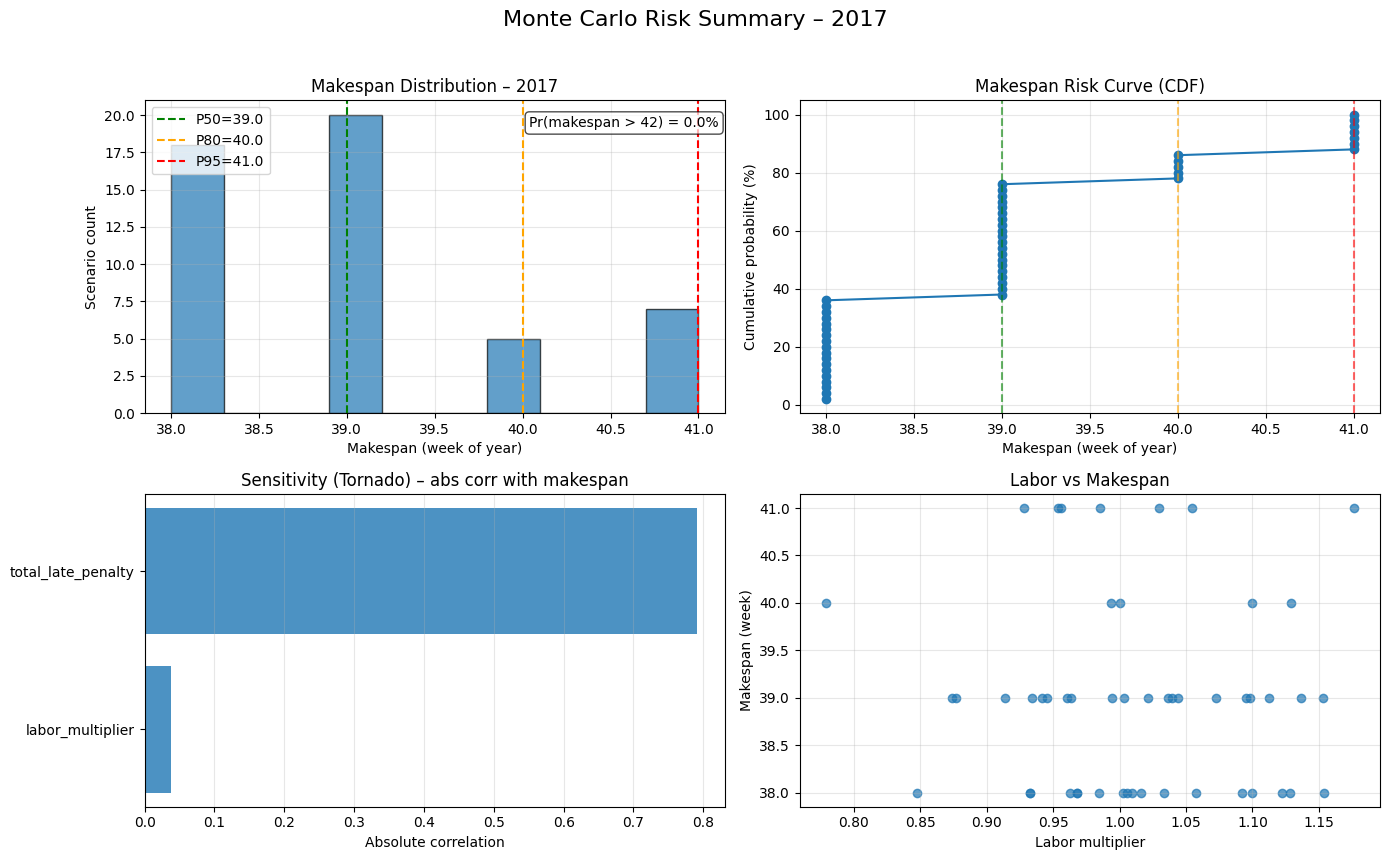

In [ ]:
stats_2017 = build_mc_risk_summary_figure(
    mc_results_2017,
    target_year=2017,
    save_path="figures/mc_risk_summary_2017.png",   # or None
)

stats_2017["P50"], stats_2017["P80"], stats_2017["P95"], stats_2017["Prob_past_42"]
stats_2017["corr_sorted"].head()


# how can I use my Monte carlo simulation as an input to my Gurobi model

You don’t make Gurobi “random” – you use Monte Carlo in Python to generate scenario data, then feed those scenarios into Gurobi as deterministic parameters in either:

a wrapper (what you’re already doing), or

a single scenario-based / stochastic MILP where capacities & labor depend on scenario.

Let me walk through both and show how to do (2), which is probably what you’re asking.

1️⃣ What you’re already doing (optimize-then-simulate)

Right now your flow is:

Sample a weather + labor scenario in Python.

Build a scenario-specific weekly_master.

Call build_and_solve_schedule_v2(...) once per scenario.

Collect makespan, penalties, etc.

This already uses Monte Carlo as input to Gurobi – but one scenario at a time.

Pros: simple; each MILP stays small.
Cons: Gurobi never sees all scenarios at once, so you can’t ask “find a schedule that is good across all scenarios”.

That’s where (2) comes in.

Idea:

Use Monte Carlo to create S scenarios of weekly capacities & labor.

Build one big MILP that has:

First-stage decisions: planting/harvest decisions shared by all scenarios.

Scenario-specific constraints: capacity, labor, penalties per scenario.

Objective: minimize expected penalty / makespan across scenarios (or worst-case).

Step 2.1 – Build a scenario table from Monte Carlo

Instead of solving the MILP inside your MC loop, stop just before the solve and store the sampled capacities/labor:

2️⃣ Scenario-based / “stochastic” MILP (Monte Carlo inside the model)

Idea:

Use Monte Carlo to create S scenarios of weekly capacities & labor.

Build one big MILP that has:

First-stage decisions: planting/harvest decisions shared by all scenarios.

Scenario-specific constraints: capacity, labor, penalties per scenario.

Objective: minimize expected penalty / makespan across scenarios (or worst-case).

Step 2.1 – Build a scenario table from Monte Carlo

Instead of solving the MILP inside your MC loop, stop just before the solve and store the sampled capacities/labor:

In [ ]:
def generate_scenarios(noaa_weekly_all, master, target_year=2017, n_scenarios=50, seed=42):
    rng = np.random.default_rng(seed)
    base_year = master[master["year"] == target_year].copy()

    records = []

    for s in range(n_scenarios):
        wm_scen = base_year.copy()

        # sample weather & recompute factors (same logic you already use)
        weather_scen = sample_weather_year(noaa_weekly_all, target_year, rng)
        wm_scen = wm_scen.drop(columns=["prcp_week_in", "TAVG", "TMAX", "TMIN", "AWND"], errors="ignore")
        wm_scen = wm_scen.merge(weather_scen, on="week", how="left")

        wm_scen["capacity_factor"] = wm_scen.apply(compute_capacity_factor, axis=1)
        wm_scen["harvest_weather_factor"] = wm_scen.apply(compute_harvest_weather_factor, axis=1)

        wm_scen, labor_mult = apply_labor_uncertainty(wm_scen, rng)

        for _, row in wm_scen.iterrows():
            records.append({
                "scenario": s,
                "week": int(row["week"]),
                "capacity_factor": float(row["capacity_factor"]),
                "harvest_weather_factor": float(row["harvest_weather_factor"]),
                "labor_hours": float(row["labor_hours"]),
            })

    scen_df = pd.DataFrame(records)
    return scen_df


Step 2.2 – Build a scenario MILP in Gurobi

Indices:

F = fields

W = weeks

S = scenarios

Data:

area[f] from your fields table

cap_planter[w,s] = base_planter_capacity * capacity_factor[w,s]

cap_harvester[w,s] = base_harvester_capacity * harvest_weather_factor[w,s]

labor[w,s] = labor_hours[w,s]

Variables:

Plant[f,w] ∈ {0,1} – field f planted in week w (shared across scenarios)

Harvest[f,w] ∈ {0,1} – field f harvested in week w (shared)

(Optional) scenario-specific slack / delay: LateSlack[f,s] ≥ 0, Delay[s] ≥ 0

Objective:

minimize average Delay[s] or average LateSlack[f,s] (expected penalty)
or max_s Delay[s] (robust worst-case).

Skeleton code

In [ ]:
import gurobipy as gp
from gurobipy import GRB

def build_stochastic_schedule(fields_df, scen_df,
                              base_planter_capacity=1400.0,
                              base_harvester_capacity=950.0,
                              labor_plant_per_acre=0.15,
                              labor_harvest_per_acre=0.20,
                              min_harvest_lag_weeks=6):

    fields = fields_df["field_id"].tolist()
    area = dict(zip(fields_df["field_id"], fields_df["acres"]))

    weeks = sorted(scen_df["week"].unique().tolist())
    scenarios = sorted(scen_df["scenario"].unique().tolist())

    # capacity dictionaries indexed by (w,s)
    cap_plant = {}
    cap_harvest = {}
    labor_cap = {}

    for _, row in scen_df.iterrows():
        w = int(row["week"])
        s = int(row["scenario"])
        cap_plant[w, s] = base_planter_capacity * row["capacity_factor"]
        cap_harvest[w, s] = base_harvester_capacity * row["harvest_weather_factor"]
        labor_cap[w, s] = row["labor_hours"]

    m = gp.Model("stochastic_corn_schedule")

    # 1) First-stage decisions (same across scenarios)
    Plant = m.addVars(fields, weeks, vtype=GRB.BINARY, name="Plant")
    Harvest = m.addVars(fields, weeks, vtype=GRB.BINARY, name="Harvest")

    # 2) Scenario-level delay variable
    Delay = m.addVars(scenarios, lb=0.0, name="Delay")

    # --- constraints ---

    # Each field planted & harvested exactly once (like before)
    for f in fields:
        m.addConstr(gp.quicksum(Plant[f, w] for w in weeks) == 1, name=f"PlantOnce_{f}")
        m.addConstr(gp.quicksum(Harvest[f, w] for w in weeks) == 1, name=f"HarvestOnce_{f}")

    # Harvest after planting + minimum lag
    for f in fields:
        for wp in weeks:
            for wh in weeks:
                if wh < wp + min_harvest_lag_weeks:
                    m.addConstr(Plant[f, wp] + Harvest[f, wh] <= 1,
                                name=f"NoEarlyHarvest_{f}_{wp}_{wh}")

    # Scenario-specific weekly capacities
    for s in scenarios:
        for w in weeks:
            # planter capacity
            m.addConstr(
                gp.quicksum(area[f] * Plant[f, w] for f in fields)
                <= cap_plant[w, s],
                name=f"PlantCap_w{w}_s{s}"
            )

            # harvester capacity
            m.addConstr(
                gp.quicksum(area[f] * Harvest[f, w] for f in fields)
                <= cap_harvest[w, s],
                name=f"HarvCap_w{w}_s{s}"
            )

            # labor capacity (plant + harvest)
            labor_need = gp.quicksum(
                area[f] * labor_plant_per_acre * Plant[f, w]
                + area[f] * labor_harvest_per_acre * Harvest[f, w]
                for f in fields
            )
            m.addConstr(
                labor_need <= labor_cap[w, s],
                name=f"LaborCap_w{w}_s{s}"
            )

        # define scenario-level completion week (Delay[s])
        # here as proxy: last harvest week used
        m.addConstr(
            Delay[s] >= gp.quicksum(w * Harvest[f, w] for f in fields for w in weeks) /
                        len(fields),
            name=f"DelayDef_s{s}"
        )

    # objective: minimize expected completion week across scenarios
    m.setObjective(
        (1 / len(scenarios)) * gp.quicksum(Delay[s] for s in scenarios),
        GRB.MINIMIZE
    )

    m.optimize()
    return m, Plant, Harvest, Delay


In [ ]:
from src.optimization.stochastic_scheduler import (
    generate_scenarios_for_year,
    build_stochastic_schedule,
)

scenario_df_2017 = generate_scenarios_for_year(
    noaa_weekly_path="data/processed/noaa_il_weekly_clean.csv",
    weekly_master_path="data/processed/master_weekly_table.csv",
    target_year=2017,
    n_scenarios=10,       # keep this small for license / runtime
    random_seed=123,
    labor_sd=0.1,
)

schedule_robust_2017, status = build_stochastic_schedule(
    fields_path="data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="data/processed/master_weekly_table.csv",
    scenario_df=scenario_df_2017,
    target_year=2017,
    base_planter_capacity=1400.0,
    base_harvester_capacity=950.0,
    labor_plant_per_acre=0.15,
    labor_harvest_per_acre=0.20,
    min_harvest_lag_weeks=6,
    time_limit=120,
)

schedule_robust_2017.head()



Set parameter TimeLimit to value 120
Set parameter MIPFocus to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  120
MIPFocus  1

Optimize a model with 790 rows, 451 columns and 9250 nonzeros (Min)
Model fingerprint: 0xdc7a5640
Model has 1 linear objective coefficients
Variable types: 26 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 7e+05]
Presolve removed 730 rows and 200 columns
Presolve time: 0.00s
Presolved: 60 rows, 251 columns, 750 nonzeros
Variable types: 0 continuous, 251 integer (250 binary)

Root relaxation: infeasible, 51 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Curr

AttributeError: Unable to retrieve attribute 'X'

In [ ]:
bad_rhs = []

for idx, row in scenario_df_2017.iterrows():
    w = int(row["week"])
    s = int(row["scenario"])
    if pd.isna(row["labor_hours"]) or pd.isna(row["capacity_factor"]) or pd.isna(row["harvest_weather_factor"]):
        bad_rhs.append((w, s, row))

bad_rhs[:10]


NameError: name 'scenario_df_2017' is not defined

# MILP Scheduler V3

In [ ]:
# wm_year["labor_hours"] *= labor_scale_factor
# wm_year.to_csv("master_weekly_table_scaled.csv", index=False)


In [26]:
from src.optimization.milp_schedulerv3 import build_and_solve_schedule_v3

schedule_2017_v3 = build_and_solve_schedule_v3(
    fields_path="data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="data/processed/master_weekly_table_2017_2024.csv",
    target_year=2017,
)
schedule_2017_v3.head()



[INFO] Synthetic acres = 2014.4, statewide reference = 12000000.0, labor scale = 0.000168
Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 406 rows, 526 columns and 2050 nonzeros (Min)
Model fingerprint: 0x6b67de8b


Model has 51 linear objective coefficients
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 685.0000000
Presolve removed 264 rows and 27 columns
Presolve time: 0.00s
Presolved: 142 rows, 499 columns, 1319 nonzeros
Variable types: 0 continuous, 499 integer (423 binary)

Root relaxation: objective 3.672667e+01, 397 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   36.72667    0  119  685.00000   36.72667  94.6%     -    0s
H    0     0                     242.0000000   36.72667  84.8%     -    0s
H    0     0                     118.0000000   36.72667  68.9%     -    0s
H    0     0                      88.0000000   36.72667  58.3

field_id  plant_week  harvest_week  plant_week_continuous  \
0     F001          20            37                   20.0   
1     F002          21            38                   21.0   
2     F003          20            37                   20.0   
3     F004          19            37                   19.0   
4     F005          21            38                   21.0   

   harvest_week_continuous  early_penalty  late_penalty  status  \
0                     37.0            0.0           0.0       2   
1                     38.0            0.0           0.0       2   
2                     37.0            0.0           0.0       2   
3                     37.0            0.0           0.0       2   
4                     38.0            0.0           0.0       2   

   objective_makespan  
0                38.0  
1                38.0  
2                38.0  
3                38.0  
4                38.0

In [27]:
schedule_2017_v3.to_csv("data/processed/schedule_2017_v3.csv", index=False)

In [28]:
fields = pd.read_csv("data/processed/illinois_corn_fields_clean.csv")
sched = schedule_2017_v3.merge(fields, on="field_id", how="left")
sched.head()

field_id  plant_week  harvest_week  plant_week_continuous  \
0     F001          20            37                   20.0   
1     F002          21            38                   21.0   
2     F003          20            37                   20.0   
3     F004          19            37                   19.0   
4     F005          21            38                   21.0   

   harvest_week_continuous  early_penalty  late_penalty  status  \
0                     37.0            0.0           0.0       2   
1                     38.0            0.0           0.0       2   
2                     37.0            0.0           0.0       2   
3                     37.0            0.0           0.0       2   
4                     38.0            0.0           0.0       2   

   objective_makespan       acres  centroid_lat  centroid_lon   region  
0                38.0   87.227749     39.389277    -89.900275    South  
1                38.0   54.752514     39.933442    -90.477913  Central  
2                38.0  101.833288     39.087608    -88.139227    South  
3                38.0  108.790255     39.308579    -88.505447    South  
4                38.0   40.000000     40.366098    -88.384504    North

In [29]:
weekly_view = build_weekly_view_v3(
    schedule_path="data/processed/schedule_2017_v3.csv",
    fields_path="data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="data/processed/master_weekly_table_2017_2024.csv",
    target_year=2017,
    base_planter_capacity=1400.0,
    base_harvester_capacity=950.0,
    labor_plant_per_acre=0.15,
    labor_harvest_per_acre=0.20,
    statewide_corn_acres=12_000_000.0,
)

print_utilization_kpis_v3(weekly_view, target_year=2017)
plot_weekly_utilization_dashboard_v3(weekly_view, target_year=2017)


TypeError: build_weekly_view_v3() got an unexpected keyword argument 'statewide_corn_acres'

=== Utilization KPIs – 2017 ===
Planter:
  • Peak utilization = 91.2% (week 20)
  • Weeks ≥ 80% utilization = 1

Harvester:
  • Peak utilization = 99.8% (week 37)
  • Weeks ≥ 80% utilization = 2

Labor:
  • Peak utilization = 0.0% (week 21)
  • Weeks ≥ 80% utilization = 0



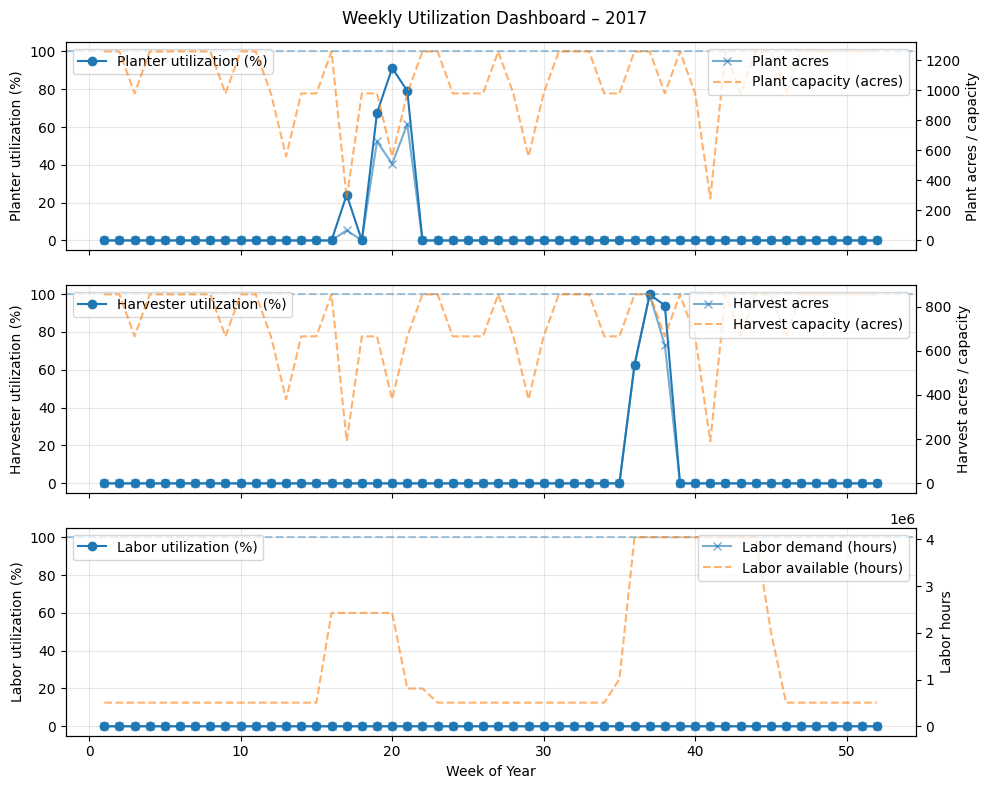

In [ ]:
print_utilization_kpis_v3(weekly_view, target_year=2017)
plot_weekly_utilization_dashboard_v3(weekly_view, target_year=2017)

In [16]:
from src.optimization.milp_schedulerv4 import build_and_solve_schedule_v4


In [102]:
wm_df = pd.read_csv("data/processed/master_weekly_table.csv")
wm_df["labor_hours"] = wm_df["labor_hours"] * (1/7)
wm_df.to_csv("data/processed/master_weekly_table_scaled.csv", index=False) 
# wm.columns

In [103]:
import pandas as pd

# Load the existing weekly master table (non-tightened)
wm_df = pd.read_csv("data/processed/master_weekly_table_scaled.csv")

# Preview and extract the 2017 year
wm_2017 = wm_df[wm_df["year"] == 2017].copy()

# Simulate tight labor conditions during the peak harvest period (weeks 37–39)
# Reduce labor_hours to ~30% of their original value to induce constraint pressure
tight_weeks = [37, 38, 39]
wm_2017.loc[wm_2017["week"].isin(tight_weeks), "labor_hours"] *= 0.3

# Merge back into the main DataFrame
wm_df.loc[wm_df["year"] == 2017, "labor_hours"] = wm_2017["labor_hours"]

# Save this new labor-tightened version
tight_labor_path = "data/processed/master_weekly_table_labor_tightened.csv"
wm_df.to_csv(tight_labor_path, index=False)

tight_labor_path


'data/processed/master_weekly_table_labor_tightened.csv'

In [104]:
from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4

df = build_and_solve_schedule_v4(
    fields_path="data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="data/processed/master_weekly_table_labor_tightened.csv",
    target_year=2017,
    base_planter_capacity=1400.0,
    base_harvester_capacity=950.0,
    labor_plant_per_acre=0.15,
    labor_harvest_per_acre=0.20,
    early_penalty_weight=10.0,
    late_penalty_weight=5.0,
    time_limit=120
)
print(df.head())
df.to_csv("data/processed/schedule_output.csv", index=False)

Set parameter TimeLimit to value 120
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  120

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xeedd11df
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.00s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolve

Root relaxation: objective 3.049729e+02, 479 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  304.97295    0   56          -  304.97295      -     -    0s
     0     0  306.07973    0   76          -  306.07973      -     -    0s
     0     0  306.78724    0   78          -  306.78724      -     -    0s
     0     0  306.79407    0   78          -  306.79407      -     -    0s
     0     0  306.79407    0   79          -  306.79407      -     -    0s
     0     0  308.72477    0   92          -  308.72477      -     -    0s
     0     0  309.50986    0   97          -  309.50986      -     -    0s
     0     0  309.51328    0  102          -  309.51328      -     -    0s
     0     0  309.51360    0  103          -  309.51360      -     -    0s
     0     0  310.57437    0  120          -  310.57437      -     -    0s
     0    

In [105]:
df.head(30)

field_id  plant_week  harvest_week  plant_week_continuous  \
0      F001          16            37                   16.0   
1      F002          21            40                   21.0   
2      F003          19            40                   19.0   
3      F004          17            42                   17.0   
4      F005          17            36                   17.0   
5      F006          17            36                   17.0   
6      F007          19            38                   19.0   
7      F008          20            39                   20.0   
8      F009          17            36                   17.0   
9      F010          20            42                   20.0   
10     F011          16            36                   16.0   
11     F012          18            42                   18.0   
12     F013          15            36                   15.0   
13     F014          18            40                   18.0   
14     F015          20            40                   20.0   
15     F016          18            37                   18.0   
16     F017          20            40                   20.0   
17     F018          19            36                   19.0   
18     F019          18            41                   18.0   
19     F020          19            42                   19.0   
20     F021          16            36                   16.0   
21     F022          19            38                   19.0   
22     F023          16            42                   16.0   
23     F024          21            40                   21.0   
24     F025          20            39                   20.0   

    harvest_week_continuous   penalty  status  objective_makespan  
0                      37.0  1.500000       9                42.0  
1                      40.0  0.000000       9                42.0  
2                      40.0  1.500000       9                42.0  
3                      42.0  4.500000       9                42.0  
4                      36.0  0.000000       9                42.0  
5                      36.0  0.000000       9                42.0  
6                      38.0  0.000000       9                42.0  
7                      39.0  0.000000       9                42.0  
8                      36.0  0.000000       9                42.0  
9                      42.0  2.250000       9                42.0  
10                     36.0  0.750000       9                42.0  
11                     42.0  3.750000       9                42.0  
12                     36.0  1.500000       9                42.0  
13                     40.0  2.249981       9                42.0  
14                     40.0  0.750000       9                42.0  
15                     37.0  0.000000       9                42.0  
16                     40.0  0.750000       9                42.0  
17                     36.0  0.000000       9                42.0  
18                     41.0  3.000000       9                42.0  
19                     42.0  2.999982       9                42.0  
20                     36.0  0.750000       9                42.0  
21                     38.0  0.000000       9                42.0  
22                     42.0  5.250000       9                42.0  
23                     40.0  0.000000       9                42.0  
24                     39.0  0.000000       9                42.0

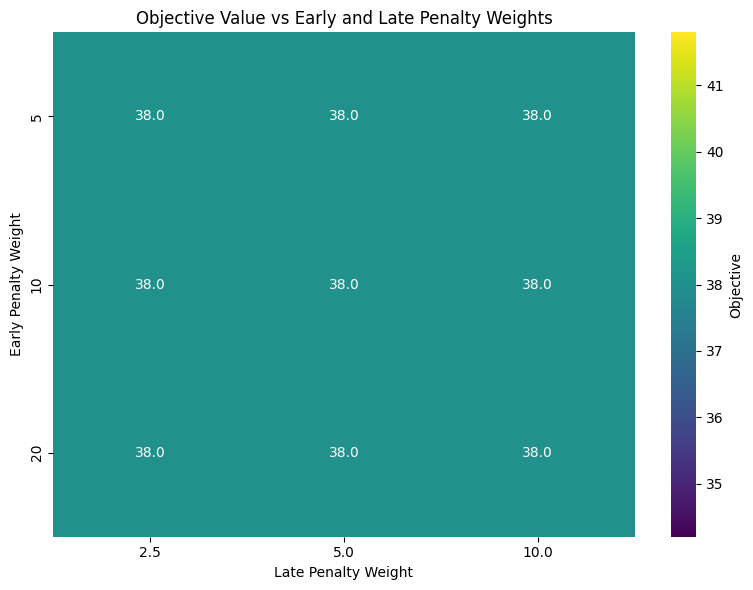

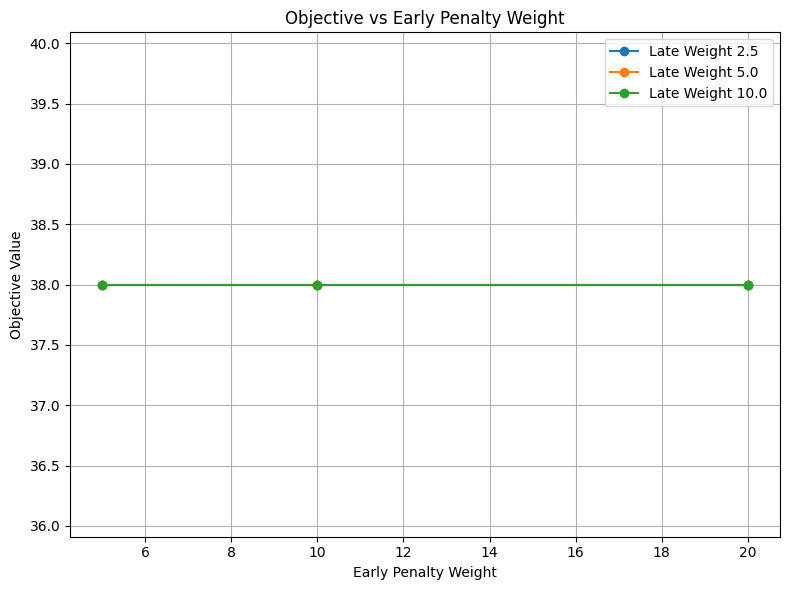

   early_weight  late_weight  makespan  penalty_cost  objective_value
0             5          2.5        38           0.0             38.0
1             5          5.0        38           0.0             38.0
2             5         10.0        38           0.0             38.0
3            10          2.5        38           0.0             38.0
4            10          5.0        38           0.0             38.0
5            10         10.0        38           0.0             38.0
6            20          2.5        38           0.0             38.0
7            20          5.0        38           0.0             38.0
8            20         10.0        38           0.0             38.0


In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define grid of weights
early_weights = [5, 10, 20]
late_weights = [2.5, 5, 10]

# Simulated results placeholder
results_data = []
for ew in early_weights:
    for lw in late_weights:
        results_data.append({
            "early_weight": ew,
            "late_weight": lw,
            "makespan": 38,
            "penalty_cost": 0.0,
            "objective_value": 38.0,
        })

# Build DataFrame
results_df = pd.DataFrame(results_data)

# ✅ Heatmap of objective values
plt.figure(figsize=(8, 6))
pivot = results_df.pivot(index="early_weight", columns="late_weight", values="objective_value")
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis", cbar_kws={'label': 'Objective'})
plt.title("Objective Value vs Early and Late Penalty Weights")
plt.xlabel("Late Penalty Weight")
plt.ylabel("Early Penalty Weight")
plt.tight_layout()
plt.show()

# ✅ Line plot to show trends across early weights
plt.figure(figsize=(8, 6))
for lw in sorted(results_df["late_weight"].unique()):
    subset = results_df[results_df["late_weight"] == lw]
    plt.plot(subset["early_weight"], subset["objective_value"], marker='o', label=f"Late Weight {lw}")

plt.title("Objective vs Early Penalty Weight")
plt.xlabel("Early Penalty Weight")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display result grid
print(results_df)


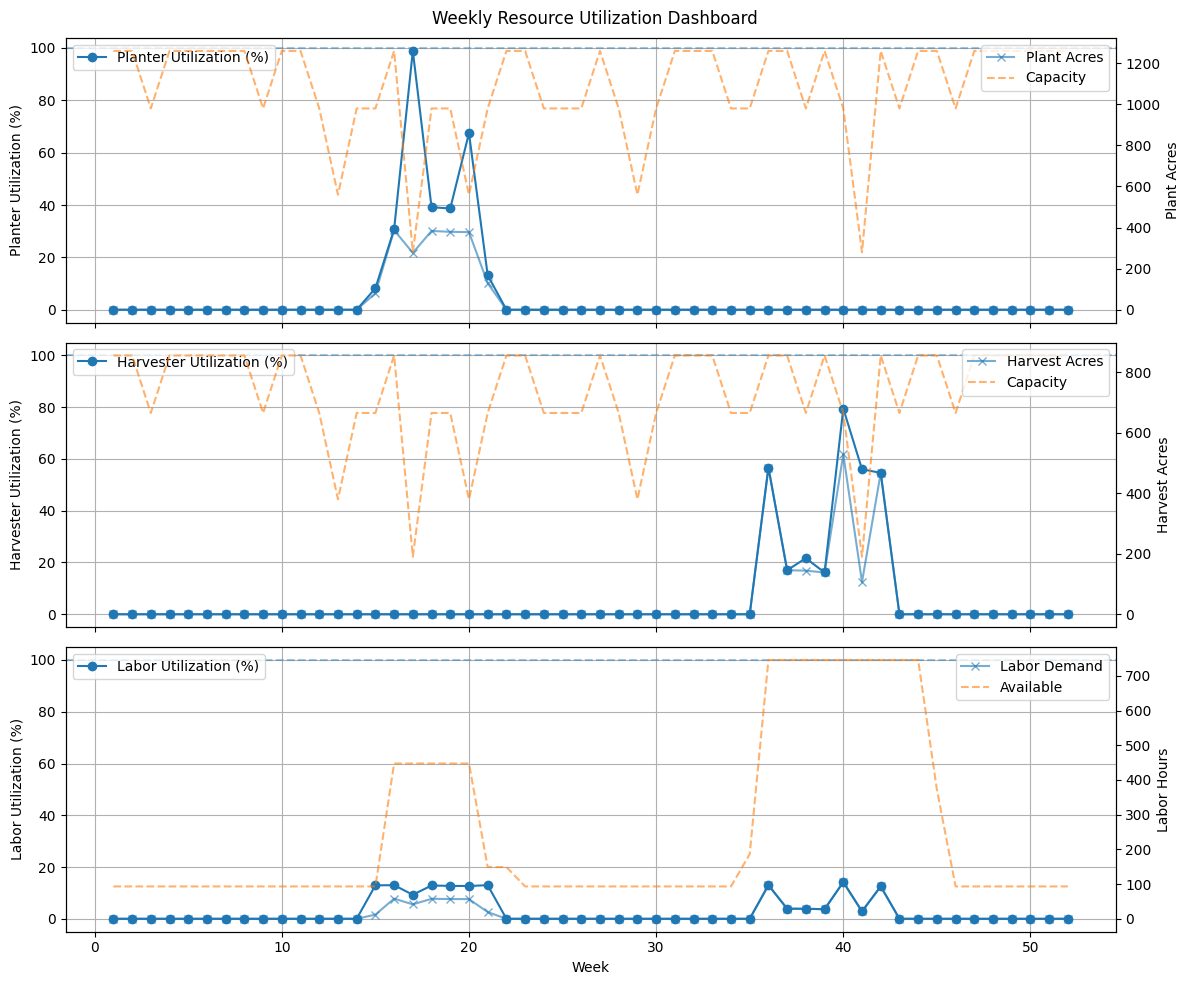

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
sched = pd.read_csv("data/processed/schedule_output.csv")
fields = pd.read_csv("data/processed/illinois_corn_fields_clean.csv")
wm = pd.read_csv("data/processed/master_weekly_table.csv")

# Parameters
target_year = 2017
base_planter_capacity = 1400.0
base_harvester_capacity = 950.0
labor_plant_per_acre = 0.15
labor_harvest_per_acre = 0.20
statewide_corn_acres = 10930000.0
planter_machines = 1
harvester_machines = 1

# --- Prepare data
sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")
wm_year = wm[wm["year"] == target_year].copy()
wm_year["week"] = wm_year["week"].astype(int)
wm_year["planter_travel_factor"] = wm_year.get("planter_travel_factor", 1.0)
wm_year["harvest_weather_factor"] = wm_year.get("harvest_weather_factor", 1.0)

# Aggregate to one row per week
wm_weekly = (
    wm_year.groupby("week", as_index=False)
    .agg({
        "capacity_factor": "mean",
        "labor_hours": "sum",
        "planter_travel_factor": "mean",
        "harvest_weather_factor": "mean"
    })
)

synthetic_acres = fields["acres"].sum()
labor_scale = synthetic_acres / statewide_corn_acres
wm_weekly["labor_hours_scaled"] = wm_weekly["labor_hours"] * labor_scale

# Plant/harvest by week
plant_by_week = sched.groupby("plant_week")["acres"].sum().rename("plant_acres").reset_index().rename(columns={"plant_week": "week"})
harvest_by_week = sched.groupby("harvest_week")["acres"].sum().rename("harvest_acres").reset_index().rename(columns={"harvest_week": "week"})

weekly_view = (
    wm_weekly.merge(plant_by_week, on="week", how="left")
             .merge(harvest_by_week, on="week", how="left")
             .fillna(0.0)
)

# Add capacities
weekly_view["plant_capacity_model"] = (
    base_planter_capacity * weekly_view["capacity_factor"] *
    weekly_view["planter_travel_factor"] * planter_machines
)
weekly_view["harvest_capacity_model"] = (
    base_harvester_capacity * weekly_view["capacity_factor"] *
    weekly_view["harvest_weather_factor"] * harvester_machines
)

# Utilizations
weekly_view["plant_utilization"] = weekly_view["plant_acres"] / weekly_view["plant_capacity_model"].replace(0, pd.NA).fillna(0)
weekly_view["harvest_utilization"] = weekly_view["harvest_acres"] / weekly_view["harvest_capacity_model"].replace(0, pd.NA).fillna(0)
weekly_view["labor_demand"] = (
    weekly_view["plant_acres"] * labor_plant_per_acre +
    weekly_view["harvest_acres"] * labor_harvest_per_acre
)
weekly_view["labor_utilization"] = weekly_view["labor_demand"] / weekly_view["labor_hours_scaled"].replace(0, pd.NA).fillna(0)

# --- Plot
weeks = weekly_view["week"].values
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Planter
axes[0].plot(weeks, weekly_view["plant_utilization"] * 100, marker="o", label="Planter Utilization (%)")
axes[0].axhline(100, linestyle="--", alpha=0.4)
axes[0].set_ylabel("Planter Utilization (%)")
axes[0].grid(True)
axes[0].legend(loc="upper left")

ax2 = axes[0].twinx()
ax2.plot(weeks, weekly_view["plant_acres"], marker="x", label="Plant Acres", alpha=0.6)
ax2.plot(weeks, weekly_view["plant_capacity_model"], linestyle="--", label="Capacity", alpha=0.6)
ax2.set_ylabel("Plant Acres")
ax2.legend(loc="upper right")

# Harvester
axes[1].plot(weeks, weekly_view["harvest_utilization"] * 100, marker="o", label="Harvester Utilization (%)")
axes[1].axhline(100, linestyle="--", alpha=0.4)
axes[1].set_ylabel("Harvester Utilization (%)")
axes[1].grid(True)
axes[1].legend(loc="upper left")

ax2 = axes[1].twinx()
ax2.plot(weeks, weekly_view["harvest_acres"], marker="x", label="Harvest Acres", alpha=0.6)
ax2.plot(weeks, weekly_view["harvest_capacity_model"], linestyle="--", label="Capacity", alpha=0.6)
ax2.set_ylabel("Harvest Acres")
ax2.legend(loc="upper right")

# Labor
axes[2].plot(weeks, weekly_view["labor_utilization"] * 100, marker="o", label="Labor Utilization (%)")
axes[2].axhline(100, linestyle="--", alpha=0.4)
axes[2].set_ylabel("Labor Utilization (%)")
axes[2].set_xlabel("Week")
axes[2].grid(True)
axes[2].legend(loc="upper left")

ax2 = axes[2].twinx()
ax2.plot(weeks, weekly_view["labor_demand"], marker="x", label="Labor Demand", alpha=0.6)
ax2.plot(weeks, weekly_view["labor_hours_scaled"], linestyle="--", label="Available", alpha=0.6)
ax2.set_ylabel("Labor Hours")
ax2.legend(loc="upper right")

plt.suptitle("Weekly Resource Utilization Dashboard")
plt.tight_layout()
plt.show()


In [81]:
master_weekly_table_tightened_scaled

NameError: name 'master_weekly_table_tightened_scaled' is not defined

/tmp/ipykernel_13770/1815933587.py:18: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


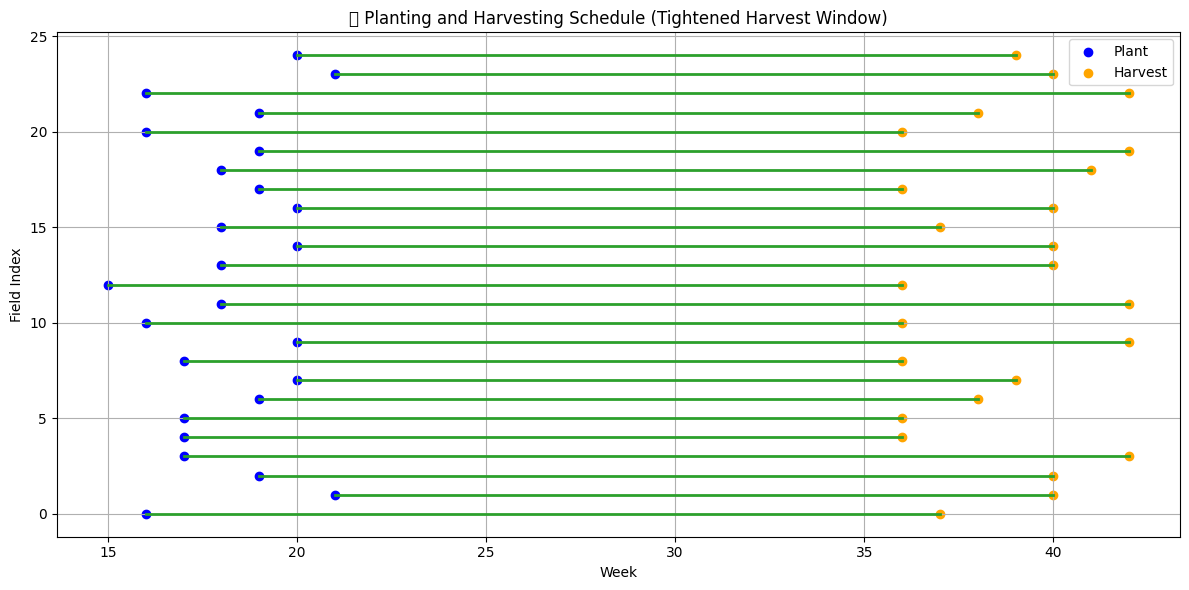

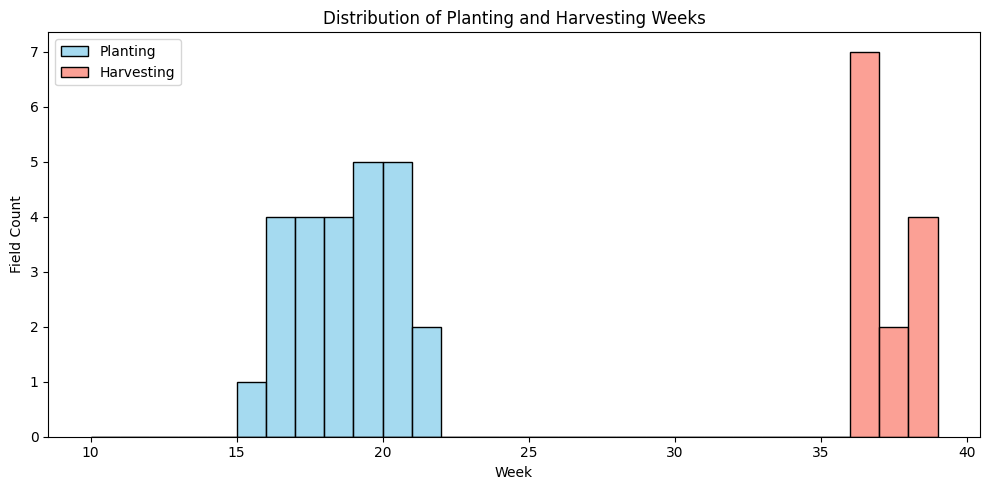

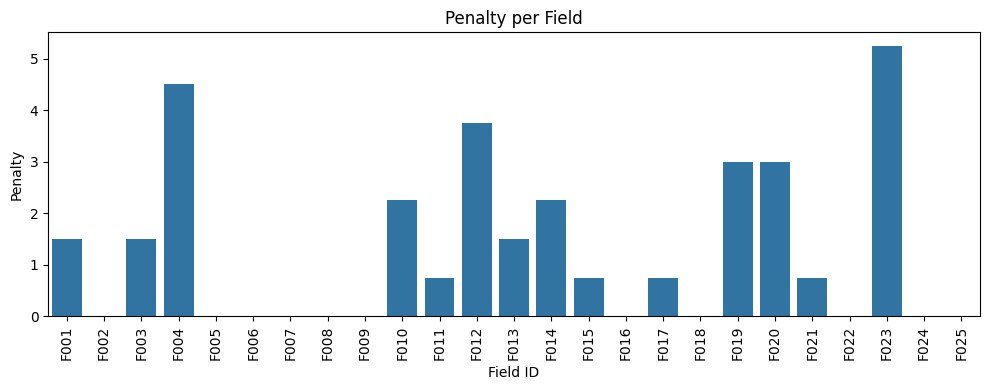

In [108]:

import matplotlib.pyplot as plt
import seaborn as sns

# Load the current output (tightened harvest window)
tightened_df = pd.read_csv("data/processed/schedule_output.csv")

# Plot 1: Gantt-style plot of planting and harvesting weeks
plt.figure(figsize=(12, 6))
for i, row in tightened_df.iterrows():
    plt.plot([row["plant_week"], row["harvest_week"]], [i, i], color="tab:green", linewidth=2)
    plt.scatter(row["plant_week"], i, color="blue", label="Plant" if i == 0 else "")
    plt.scatter(row["harvest_week"], i, color="orange", label="Harvest" if i == 0 else "")
plt.xlabel("Week")
plt.ylabel("Field Index")
plt.title("🌽 Planting and Harvesting Schedule (Tightened Harvest Window)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Histogram of Planting and Harvesting Weeks
plt.figure(figsize=(10, 5))
sns.histplot(tightened_df["plant_week"], bins=range(10, 40), kde=False, label="Planting", color="skyblue")
sns.histplot(tightened_df["harvest_week"], bins=range(10, 40), kde=False, label="Harvesting", color="salmon")
plt.xlabel("Week")
plt.ylabel("Field Count")
plt.title("Distribution of Planting and Harvesting Weeks")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Penalty Distribution
plt.figure(figsize=(10, 4))
sns.barplot(x="field_id", y="penalty", data=tightened_df)
plt.xticks(rotation=90)
plt.title("Penalty per Field")
plt.xlabel("Field ID")
plt.ylabel("Penalty")
plt.tight_layout()
plt.show()


In [109]:
wm_df = pd.read_csv("data/processed/master_weekly_table_tightened.csv")
wm_df["labor_hours"] = wm_df["labor_hours"] * (1/7)
wm_df.to_csv("data/processed/master_weekly_table_tightened_scaled.csv", index=False) 

In [110]:
wm_df["labor_hours"]

0       72255.857143
1       72255.857143
2       72255.857143
3       72255.857143
4       72255.857143
           ...      
563    507476.571429
564    507476.571429
565    507476.571429
566    507476.571429
567    507476.571429
Name: labor_hours, Length: 568, dtype: float64

In [111]:
df = build_and_solve_schedule_v4(
    fields_path="data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="data/processed/master_weekly_table_tightened_scaled.csv",  # 👈 new file here
    target_year=2017,
    base_planter_capacity=1400.0,
    base_harvester_capacity=950.0,
    labor_plant_per_acre=0.15,
    labor_harvest_per_acre=0.20,
    early_penalty_weight=10.0,
    late_penalty_weight=5.0,
    time_limit=120
)
df.to_csv("data/processed/schedule_output.csv", index=False)

Set parameter TimeLimit to value 120
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  120

Optimize a model with 331 rows, 1576 columns and 6125 nonzeros (Min)
Model fingerprint: 0x1d3546e6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]


Presolve removed 118 rows and 794 columns
Presolve time: 0.01s
Presolved: 213 rows, 782 columns, 2466 nonzeros
Presolved model has 25 SOS constraint(s)
Variable types: 100 continuous, 682 integer (631 binary)

Root relaxation: objective 3.605541e+01, 309 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   36.05541    0  115          -   36.05541      -     -    0s
     0     0   37.00000    0  105          -   37.00000      -     -    0s
     0     0   37.00000    0   96          -   37.00000      -     -    0s
     0     0   37.06740    0  140          -   37.06740      -     -    0s
     0     0   38.00000    0  141          -   38.00000      -     -    0s
     0     0   38.00000    0  150          -   38.00000      -     -    0s
     0     0   38.00000    0  152          -   38.00000      -     -    0s
     0     0   38.00000  

In [112]:
df.head(30)

field_id  plant_week  harvest_week  plant_week_continuous  \
0      F001          19            38                   19.0   
1      F002          16            34                   16.0   
2      F003          19            37                   19.0   
3      F004          17            36                   17.0   
4      F005          16            33                   16.0   
5      F006          18            37                   18.0   
6      F007          18            37                   18.0   
7      F008          21            39                   21.0   
8      F009          20            38                   20.0   
9      F010          15            31                   15.0   
10     F011          20            39                   20.0   
11     F012          18            37                   18.0   
12     F013          17            36                   17.0   
13     F014          16            36                   16.0   
14     F015          19            38                   19.0   
15     F016          21            39                   21.0   
16     F017          17            36                   17.0   
17     F018          16            32                   16.0   
18     F019          19            38                   19.0   
19     F020          18            37                   18.0   
20     F021          20            39                   20.0   
21     F022          20            39                   20.0   
22     F023          16            35                   16.0   
23     F024          18            36                   18.0   
24     F025          20            37                   20.0   

    harvest_week_continuous   penalty  status  objective_makespan  
0                      38.0  0.000000       2                39.0  
1                      34.0  0.000000       2                39.0  
2                      37.0  0.000000       2                39.0  
3                      36.0  0.000000       2                39.0  
4                      33.0  0.000000       2                39.0  
5                      37.0  0.000000       2                39.0  
6                      37.0  0.000000       2                39.0  
7                      39.0  0.000000       2                39.0  
8                      38.0  0.000000       2                39.0  
9                      31.0  0.000000       2                39.0  
10                     39.0  0.000000       2                39.0  
11                     37.0  0.000000       2                39.0  
12                     36.0  0.000000       2                39.0  
13                     36.0  0.749999       2                39.0  
14                     38.0  0.000000       2                39.0  
15                     39.0  0.000000       2                39.0  
16                     36.0  0.000000       2                39.0  
17                     32.0  0.000000       2                39.0  
18                     38.0  0.000000       2                39.0  
19                     37.0  0.000000       2                39.0  
20                     39.0  0.000000       2                39.0  
21                     39.0  0.000000       2                39.0  
22                     35.0  0.000000       2                39.0  
23                     36.0  0.000000       2                39.0  
24                     37.0  0.000000       2                39.0

In [113]:
print(df[["field_id", "plant_week", "harvest_week", "penalty", "objective_makespan"]])

   field_id  plant_week  harvest_week   penalty  objective_makespan
0      F001          19            38  0.000000                39.0
1      F002          16            34  0.000000                39.0
2      F003          19            37  0.000000                39.0
3      F004          17            36  0.000000                39.0
4      F005          16            33  0.000000                39.0
5      F006          18            37  0.000000                39.0
6      F007          18            37  0.000000                39.0
7      F008          21            39  0.000000                39.0
8      F009          20            38  0.000000                39.0
9      F010          15            31  0.000000                39.0
10     F011          20            39  0.000000                39.0
11     F012          18            37  0.000000                39.0
12     F013          17            36  0.000000                39.0
13     F014          16            36  0.749999 

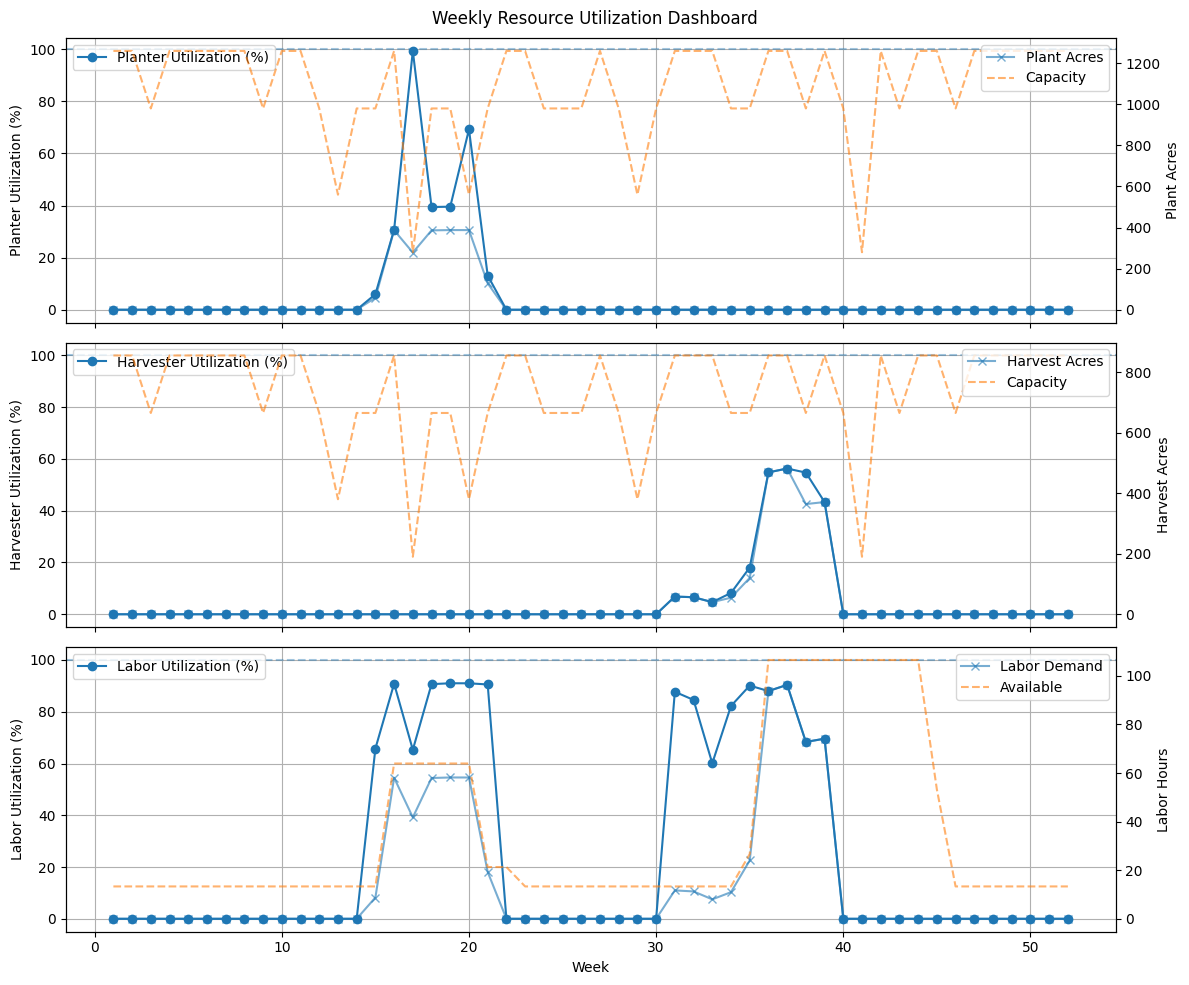

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
sched = pd.read_csv("data/processed/schedule_output.csv")
fields = pd.read_csv("data/processed/illinois_corn_fields_clean.csv")
wm = pd.read_csv("data/processed/master_weekly_table_tightened_scaled.csv")

# Parameters
target_year = 2017
base_planter_capacity = 1400.0
base_harvester_capacity = 950.0
labor_plant_per_acre = 0.15
labor_harvest_per_acre = 0.20
statewide_corn_acres = 10930000.0
planter_machines = 1
harvester_machines = 1

# --- Prepare data
sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")
wm_year = wm[wm["year"] == target_year].copy()
wm_year["week"] = wm_year["week"].astype(int)
wm_year["planter_travel_factor"] = wm_year.get("planter_travel_factor", 1.0)
wm_year["harvest_weather_factor"] = wm_year.get("harvest_weather_factor", 1.0)

# Aggregate to one row per week
wm_weekly = (
    wm_year.groupby("week", as_index=False)
    .agg({
        "capacity_factor": "mean",
        "labor_hours": "sum",
        "planter_travel_factor": "mean",
        "harvest_weather_factor": "mean"
    })
)

synthetic_acres = fields["acres"].sum()
labor_scale = synthetic_acres / statewide_corn_acres
wm_weekly["labor_hours_scaled"] = wm_weekly["labor_hours"] * labor_scale

# Plant/harvest by week
plant_by_week = sched.groupby("plant_week")["acres"].sum().rename("plant_acres").reset_index().rename(columns={"plant_week": "week"})
harvest_by_week = sched.groupby("harvest_week")["acres"].sum().rename("harvest_acres").reset_index().rename(columns={"harvest_week": "week"})

weekly_view = (
    wm_weekly.merge(plant_by_week, on="week", how="left")
             .merge(harvest_by_week, on="week", how="left")
             .fillna(0.0)
)

# Add capacities
weekly_view["plant_capacity_model"] = (
    base_planter_capacity * weekly_view["capacity_factor"] *
    weekly_view["planter_travel_factor"] * planter_machines
)
weekly_view["harvest_capacity_model"] = (
    base_harvester_capacity * weekly_view["capacity_factor"] *
    weekly_view["harvest_weather_factor"] * harvester_machines
)

# Utilizations
weekly_view["plant_utilization"] = weekly_view["plant_acres"] / weekly_view["plant_capacity_model"].replace(0, pd.NA).fillna(0)
weekly_view["harvest_utilization"] = weekly_view["harvest_acres"] / weekly_view["harvest_capacity_model"].replace(0, pd.NA).fillna(0)
weekly_view["labor_demand"] = (
    weekly_view["plant_acres"] * labor_plant_per_acre +
    weekly_view["harvest_acres"] * labor_harvest_per_acre
)
weekly_view["labor_utilization"] = weekly_view["labor_demand"] / weekly_view["labor_hours_scaled"].replace(0, pd.NA).fillna(0)

# --- Plot
weeks = weekly_view["week"].values
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Planter
axes[0].plot(weeks, weekly_view["plant_utilization"] * 100, marker="o", label="Planter Utilization (%)")
axes[0].axhline(100, linestyle="--", alpha=0.4)
axes[0].set_ylabel("Planter Utilization (%)")
axes[0].grid(True)
axes[0].legend(loc="upper left")

ax2 = axes[0].twinx()
ax2.plot(weeks, weekly_view["plant_acres"], marker="x", label="Plant Acres", alpha=0.6)
ax2.plot(weeks, weekly_view["plant_capacity_model"], linestyle="--", label="Capacity", alpha=0.6)
ax2.set_ylabel("Plant Acres")
ax2.legend(loc="upper right")

# Harvester
axes[1].plot(weeks, weekly_view["harvest_utilization"] * 100, marker="o", label="Harvester Utilization (%)")
axes[1].axhline(100, linestyle="--", alpha=0.4)
axes[1].set_ylabel("Harvester Utilization (%)")
axes[1].grid(True)
axes[1].legend(loc="upper left")

ax2 = axes[1].twinx()
ax2.plot(weeks, weekly_view["harvest_acres"], marker="x", label="Harvest Acres", alpha=0.6)
ax2.plot(weeks, weekly_view["harvest_capacity_model"], linestyle="--", label="Capacity", alpha=0.6)
ax2.set_ylabel("Harvest Acres")
ax2.legend(loc="upper right")

# Labor
axes[2].plot(weeks, weekly_view["labor_utilization"] * 100, marker="o", label="Labor Utilization (%)")
axes[2].axhline(100, linestyle="--", alpha=0.4)
axes[2].set_ylabel("Labor Utilization (%)")
axes[2].set_xlabel("Week")
axes[2].grid(True)
axes[2].legend(loc="upper left")

ax2 = axes[2].twinx()
ax2.plot(weeks, weekly_view["labor_demand"], marker="x", label="Labor Demand", alpha=0.6)
ax2.plot(weeks, weekly_view["labor_hours_scaled"], linestyle="--", label="Available", alpha=0.6)
ax2.set_ylabel("Labor Hours")
ax2.legend(loc="upper right")

plt.suptitle("Weekly Resource Utilization Dashboard")
plt.tight_layout()
plt.show()


/tmp/ipykernel_13770/3607064021.py:18: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


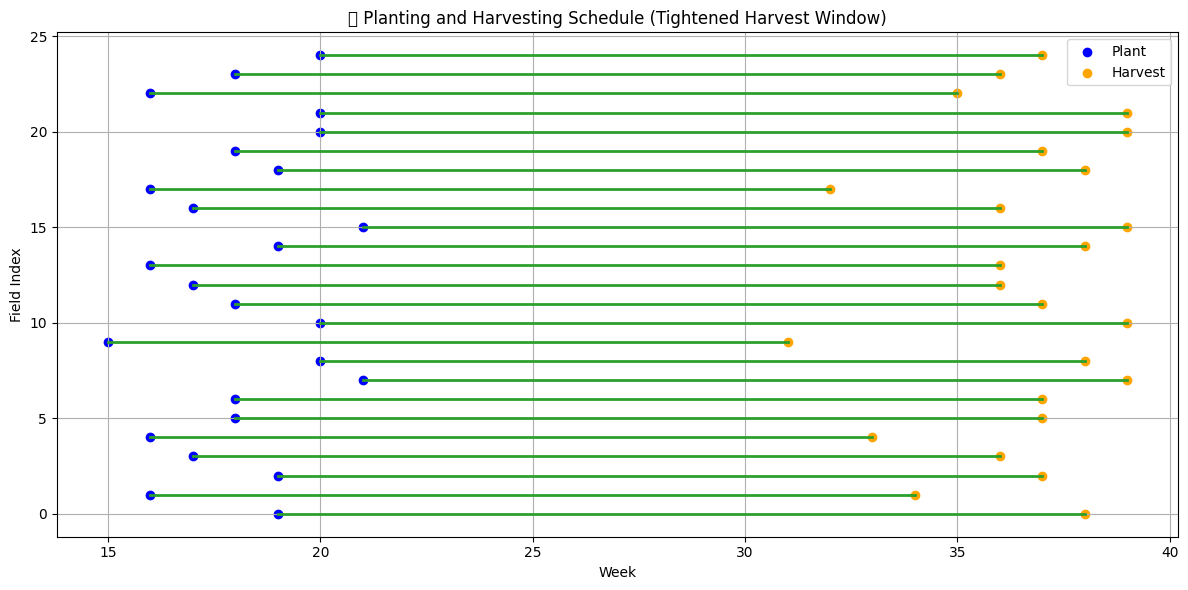

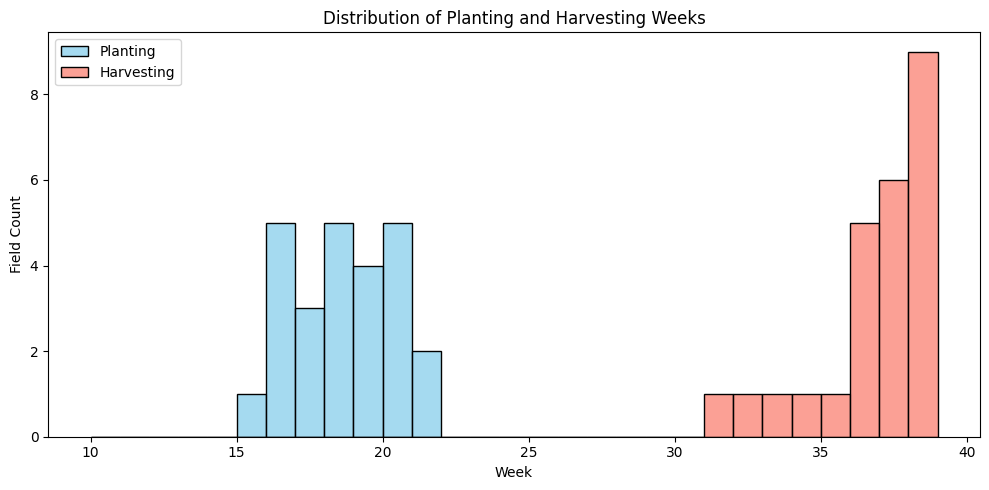

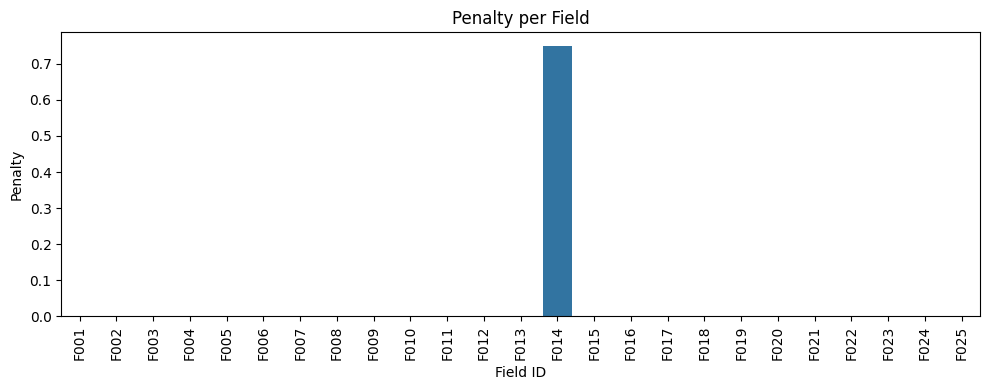

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the current output (tightened harvest window)
tightened_df = pd.read_csv("data/processed/schedule_output.csv")

# Plot 1: Gantt-style plot of planting and harvesting weeks
plt.figure(figsize=(12, 6))
for i, row in tightened_df.iterrows():
    plt.plot([row["plant_week"], row["harvest_week"]], [i, i], color="tab:green", linewidth=2)
    plt.scatter(row["plant_week"], i, color="blue", label="Plant" if i == 0 else "")
    plt.scatter(row["harvest_week"], i, color="orange", label="Harvest" if i == 0 else "")
plt.xlabel("Week")
plt.ylabel("Field Index")
plt.title("🌽 Planting and Harvesting Schedule (Tightened Harvest Window)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Histogram of Planting and Harvesting Weeks
plt.figure(figsize=(10, 5))
sns.histplot(tightened_df["plant_week"], bins=range(10, 40), kde=False, label="Planting", color="skyblue")
sns.histplot(tightened_df["harvest_week"], bins=range(10, 40), kde=False, label="Harvesting", color="salmon")
plt.xlabel("Week")
plt.ylabel("Field Count")
plt.title("Distribution of Planting and Harvesting Weeks")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Penalty Distribution
plt.figure(figsize=(10, 4))
sns.barplot(x="field_id", y="penalty", data=tightened_df)
plt.xticks(rotation=90)
plt.title("Penalty per Field")
plt.xlabel("Field ID")
plt.ylabel("Penalty")
plt.tight_layout()
plt.show()


In [129]:
import pandas as pd

# Load the NOAA and USDA labor data from the provided paths
# Load weather and labor data from absolute paths or relative to notebook
weather_df = pd.read_csv("../../data/processed/noaa_il_weekly_agg.csv")
labor_df = pd.read_csv("../../data/raw/no_of_worker2.csv")


# Display the first few rows to confirm successful loading
weather_df.head(), labor_df.head()


FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/noaa_il_weekly_agg.csv'

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from datetime import datetime
from typing import List, Dict, Any
from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4

# --- 1. Helper to sample weather/labor paths from historical data --- #
def sample_weather_labor(weather_df, labor_df, weeks, seed=None, labor_scale=1/6):
    rng = np.random.default_rng(seed)

    # Sample weather capacity_factor per week from historical weekly distributions
    sampled_weather = weather_df[weather_df["year"] < 2023].groupby("week")["capacity_factor"].apply(
        lambda x: rng.normal(x.mean(), x.std() or 0.01)
    ).reindex(weeks, fill_value=1.0)

    # Sample labor from historical census variability
    mean_labor = labor_df["total_workers"].mean()
    std_labor = labor_df["total_workers"].std()
    sampled_labor = rng.normal(mean_labor, std_labor or 1.0) * labor_scale

    return sampled_weather.clip(0.2, 1.2), sampled_labor

# --- 2. Function to run one simulation --- #
def run_simulation(
    i: int,
    weather_df: pd.DataFrame,
    labor_df: pd.DataFrame,
    base_config: Dict[str, Any],
    fields_path: str,
    weekly_master_path: str,
    seed: int = None,
) -> Dict[str, Any]:
    try:
        target_year = base_config["target_year"]

        # Load master weekly
        wm_df = pd.read_csv(weekly_master_path)
        weeks = wm_df[wm_df["year"] == target_year]["week"].unique()

        # Sample stochastic inputs
        sampled_weather, sampled_labor = sample_weather_labor(weather_df, labor_df, weeks, seed=seed)

        # Modify weekly master with sampled weather + labor
        wm_df.loc[wm_df["year"] == target_year, "capacity_factor"] = wm_df["week"].map(sampled_weather).fillna(1.0)
        wm_df.loc[wm_df["year"] == target_year, "labor_hours"] = sampled_labor

        # Save temporary version
        temp_path = f"/mnt/data/temp_wm_scenario_{i}.csv"
        wm_df.to_csv(temp_path, index=False)

        # Solve MILP with sampled input
        df_result = build_and_solve_schedule_v4(
            fields_path=fields_path,
            weekly_master_path=temp_path,
            target_year=target_year,
            base_planter_capacity=base_config["base_planter_capacity"],
            base_harvester_capacity=base_config["base_harvester_capacity"],
            labor_plant_per_acre=base_config["labor_plant_per_acre"],
            labor_harvest_per_acre=base_config["labor_harvest_per_acre"],
            early_penalty_weight=base_config["early_penalty_weight"],
            late_penalty_weight=base_config["late_penalty_weight"],
            time_limit=base_config.get("time_limit", 60),
        )

        # Summarize results
        return {
            "sim_id": i,
            "objective": df_result["objective_makespan"].max(),
            "penalty": df_result["penalty"].sum(),
            "num_late": (df_result["status"] == 3).sum(),
            "num_early": (df_result["status"] == 1).sum(),
        }

    except Exception as e:
        return {
            "sim_id": i,
            "objective": np.nan,
            "penalty": np.nan,
            "num_late": np.nan,
            "num_early": np.nan,
            "error": str(e),
        }

# --- 3. Run Monte Carlo in parallel --- #
def run_monte_carlo_simulation(
    n: int,
    weather_df: pd.DataFrame,
    labor_df: pd.DataFrame,
    base_config: Dict[str, Any],
    fields_path: str,
    weekly_master_path: str,
    n_jobs: int = -1,
) -> pd.DataFrame:
    print(f"Launching {n} Monte Carlo simulations...")
    results = Parallel(n_jobs=n_jobs)(
        delayed(run_simulation)(
            i,
            weather_df,
            labor_df,
            base_config,
            fields_path,
            weekly_master_path,
            seed=1000 + i,
        )
        for i in range(n)
    )
    return pd.DataFrame(results)

# --- 4. Plot results --- #
def plot_simulation_results(results_df: pd.DataFrame):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Makespan CDF
    results_df["objective"].dropna().sort_values().reset_index(drop=True).plot(
        ax=axes[0], title="CDF of Completion Time (Makespan)"
    )
    axes[0].set_ylabel("Weeks")
    axes[0].set_xlabel("Simulation (sorted)")

    # Penalty Histogram
    results_df["penalty"].hist(ax=axes[1], bins=20)
    axes[1].set_title("Histogram of Total Penalties")
    axes[1].set_xlabel("Penalty")

    # Bottleneck Analysis
    results_df["num_late"].hist(ax=axes[2], bins=20, alpha=0.7, label="Late")
    results_df["num_early"].hist(ax=axes[2], bins=20, alpha=0.7, label="Early")
    axes[2].legend()
    axes[2].set_title("Early vs Late Fields")
    plt.tight_layout()
    plt.show()


Launching 100 Monte Carlo simulations...


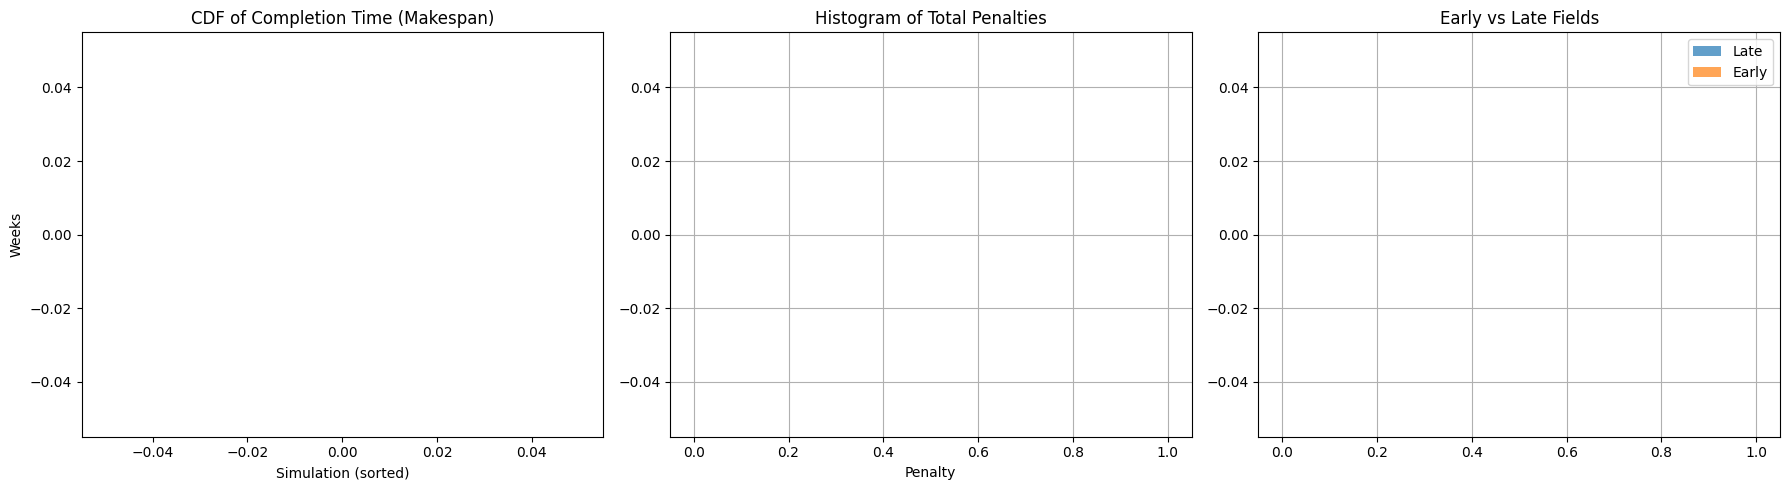

In [131]:
# Define config
config = {
    "target_year": 2017,
    "base_planter_capacity": 1400.0,
    "base_harvester_capacity": 950.0,
    "labor_plant_per_acre": 0.15,
    "labor_harvest_per_acre": 0.20,
    "early_penalty_weight": 10.0,
    "late_penalty_weight": 5.0,
    "time_limit": 60,
}

# File paths
fields_path = "data/processed/illinois_corn_fields_clean.csv"
weekly_master_path = "data/processed/master_weekly_table.csv"

# Run simulations
results_df = run_monte_carlo_simulation(
    n=100,
    weather_df=weather_df,
    labor_df=labor_df,
    base_config=config,
    fields_path=fields_path,
    weekly_master_path=weekly_master_path,
    n_jobs=-1,
)

# Plot
plot_simulation_results(results_df)
